In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %pip install tqdm

In [2]:
import os
import json
import numpy as np
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
from IPython.display import HTML

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
data_path = Path('/Users/karankamath/Desktop/ARC-master/data')
train_path = data_path / 'training'
eval_path = data_path / 'evaluation'
test_path = data_path / 'test'

train_tasks = { task.stem: json.load(task.open()) for task in train_path.iterdir() }
eval_tasks = { task.stem: json.load(task.open()) for task in eval_path.iterdir() }

In [4]:
cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

def plot_pictures(pictures, labels):
    fig, axs = plt.subplots(1, len(pictures), figsize=(2*len(pictures),32))
    for i, (pict, label) in enumerate(zip(pictures, labels)):
        axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
        axs[i].set_title(label)
    plt.show()

def plot_sample(sample, predict=None):
    if predict is None:
        plot_pictures([sample['input'], sample['output']], ['Input', 'Output'])
    elif 'output' in sample:
        plot_pictures([sample['input'], sample['output'], predict], ['Input', 'Output', 'Predict'])
    else:
        plot_pictures([sample['input'], predict], ['Input', 'Predict'])

def inp2img(inp):
    inp = np.array(inp)
    img = np.full((10, inp.shape[0], inp.shape[1]), 0, dtype=np.uint8)
    for i in range(10):
        img[i] = (inp==i)
    return img

def input_output_shape_is_same(task):
    return all([np.array(el['input']).shape == np.array(el['output']).shape for el in task['train']])


def calk_score(task_test, predict):
    return [int(np.equal(sample['output'], pred).all()) for sample, pred in zip(task_test, predict)]

## Checking for 2 tasks

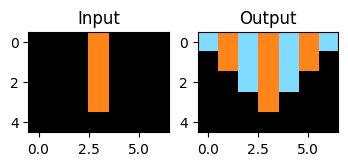

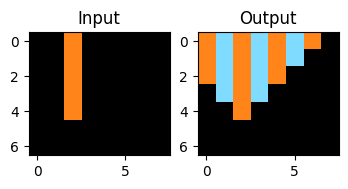

In [5]:
task = train_tasks["db3e9e38"]["train"]
for sample in task:
    plot_sample(sample)

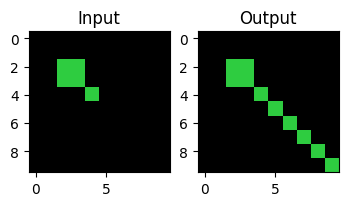

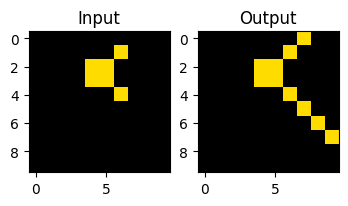

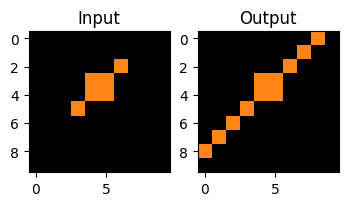

In [6]:
task = train_tasks["7ddcd7ec"]["train"]
for sample in task:
    plot_sample(sample)

## The Model

The model consists of a single 3x3 convolutional layer, followed by a 1x1 convolutional layer. Here `num_states` represents how many values a single cell could have; in this case 10, one for each color. Down the road, we may want to add a hidden state, concatinating it to the input, then removing it from the output.

The foward pass of the model will repeatedly pass the grid state through the CA transition for `steps` number of times.

In [7]:
class CAModel(nn.Module):
    def __init__(self, num_states):
        super(CAModel, self).__init__()
        self.transition = nn.Sequential(
            nn.Conv2d(num_states, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, num_states, kernel_size=1)
        )

    def forward(self, x, steps=1):
        for _ in range(steps):
            x = self.transition(torch.softmax(x, dim=1))
        return x

## Training

This "recurrent CNN" can be quite to difficult to train. After trying a few ideas, this seemed to be the best approach that I encountered:

* For every value $n$ = $1, ..., N$:
    1. Train the model with $n$ `steps` to produce the output from input
    2. Train the model with 1 `steps` to produce output from output
        * This enforces that the CA stabilizes after reaching a solution
        
In this way the model will try to get as close to a solution as possible in 1 step, then try to get closer in the next step, and so on until $N$ steps. For now I will use $N = 10$ = `max_steps`. I will also set the learning rate to decay with each additional step: $LR = 0.1 / (n * 2) $

In [8]:
import math
import random

def solve_task(task, model, max_steps=12):
    # model = CAModel(10).to(device)
    num_epochs = 100
    num_repeat = 10
    criterion = nn.CrossEntropyLoss()
    losses = np.zeros((num_repeat - 1) * num_epochs)

    for i in range(1, num_repeat):
        if i > num_repeat-4:
            num_steps = max_steps
        else:
            num_steps = random.randint(1, max_steps)
        optimizer = torch.optim.Adam(model.parameters(), lr=(0.04 / i))

        for e in range(num_epochs):
            optimizer.zero_grad()
            loss = 0.0

            for sample in task:
                # predict output from input
                x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
                y = torch.tensor(sample["output"]).long().unsqueeze(0).to(device)
                y_pred = model(x, num_steps)
                loss += criterion(y_pred, y)

                # predit output from output
                # enforces stability after solution is reached
                y_in = torch.from_numpy(inp2img(sample["output"])).unsqueeze(0).float().to(device)
                y_pred = model(y_in, 1)
                loss += criterion(y_pred, y)

            loss.backward()
            optimizer.step()
            losses[(i - 1) * num_epochs + e] = loss.item()
    return model, num_steps, losses

@torch.no_grad()
def predict(model, task):
    predictions = []
    for sample in task:
        x = torch.from_numpy(inp2img(sample["input"])).unsqueeze(0).float().to(device)
        pred = model(x, 200).argmax(1).squeeze().cpu().numpy()
        predictions.append(pred)
    return predictions

# task = train_tasks["dbc1a6ce"]["train"]
# model, num_steps, losses = solve_task(task)

In [9]:
# plt.plot(losses)

## Training and Evaluation

In [10]:
def evaluate(tasks):
    result = []
    predictions = []
    model = CAModel(10).to(device)
    for idx, task in tqdm(tasks.items()):
        if input_output_shape_is_same(task):
            model, _, _ = solve_task(task["train"], model)
            pred = predict(model, task["test"])
            score = calk_score(task["test"], pred)
        else:
            pred = [el["input"] for el in task["test"]]
            score = [0] * len(task["test"])

        predictions.append(pred)
        result.append(score)
    return result, predictions

    # for task in tqdm(tasks.values()):
    #     if input_output_shape_is_same(task):
    #         pred = predict(model, task["test"])
    #         score = calk_score(task["test"], pred)
    #     else:
    #         pred = [el["input"] for el in task["test"]]
    #         score = [0] * len(task["test"])

    #     predictions.append(pred)
    #     result.append(score)
    
    # return result, predictions

In [11]:
train_result1, train_predictions1 = evaluate(eval_tasks)
train_solved1 = [any(score) for score in train_result1]

total1 = sum([len(score) for score in train_result1])
print(f"solved : {sum(train_solved1)} from {total1} ({sum(train_solved1)/total1})")

100%|██████████| 400/400 [40:26<00:00,  6.07s/it]

solved : 0 from 419 (0.0)


## Model Correctness

In [12]:
def count_true(boolean_list):
    count = 0
    for element in boolean_list:
        if element:
            count += 1
    return count

count_true(train_solved1)

0

In [13]:
def get_accuracy(oup, pred):
    r, c = len(oup), len(oup[0])
    correct = 0
    total = 0
    for i in range(r):
        for j in range(c):
            total += 1
            if oup[i][j] == pred[i][j]:
                correct += 1
    return correct / total


0it [00:00, ?it/s]

Accuracy:  0.0


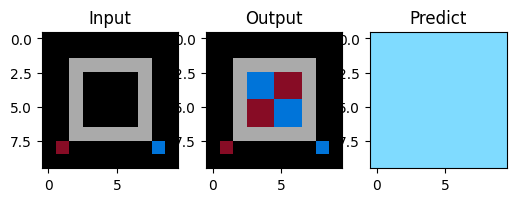

2it [00:00,  6.66it/s]

Accuracy:  0.896551724137931


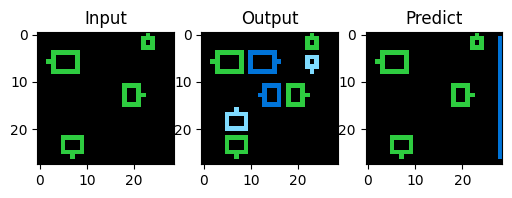

3it [00:00,  6.50it/s]

Accuracy:  0.9333333333333333


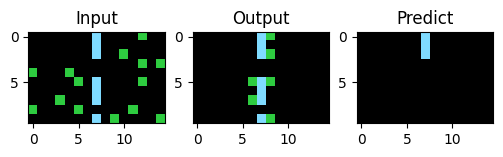

4it [00:00,  6.77it/s]

Accuracy:  0.75


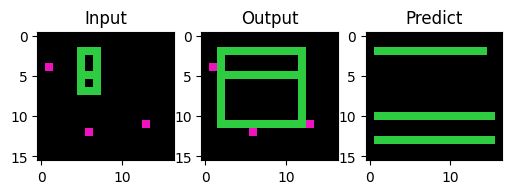

5it [00:00,  6.72it/s]

Accuracy:  0.6583333333333333


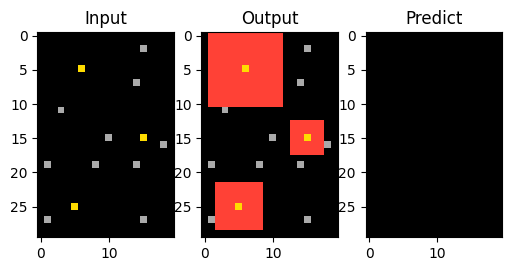

7it [00:00,  8.56it/s]

Accuracy:  0.33088235294117646


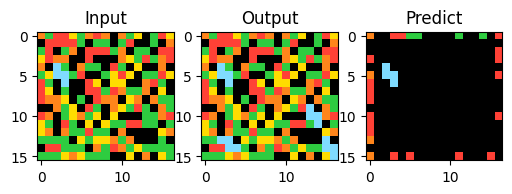

8it [00:01,  8.00it/s]

Accuracy:  0.5355029585798816


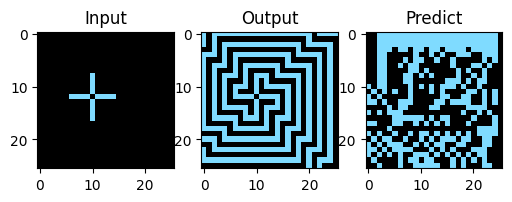

9it [00:01,  7.64it/s]

Accuracy:  0.6


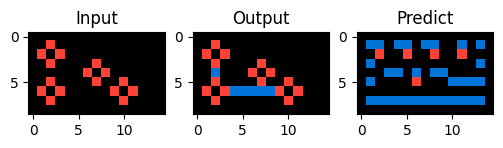

10it [00:01,  6.08it/s]

Accuracy:  0.4293628808864266


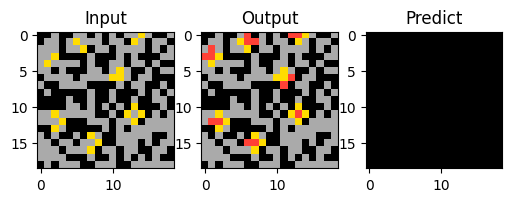

11it [00:01,  6.52it/s]

Accuracy:  0.5404663923182441


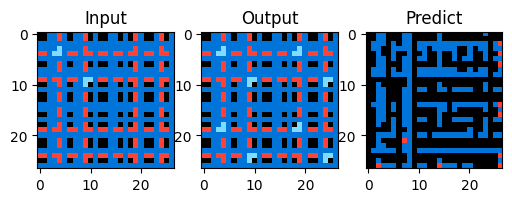

12it [00:01,  6.85it/s]

Accuracy:  0.07444444444444444


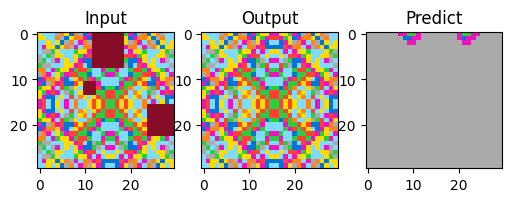

13it [00:01,  7.15it/s]

Accuracy:  0.79


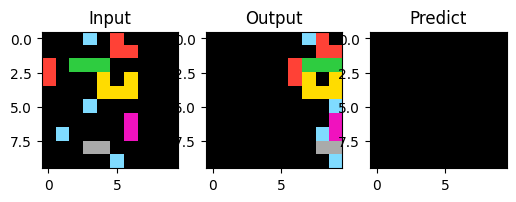

14it [00:01,  7.57it/s]

Accuracy:  0.78


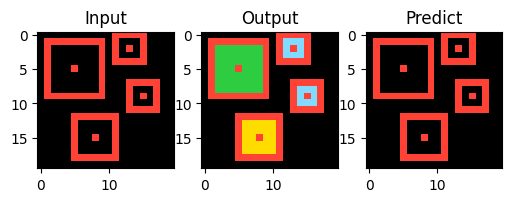

16it [00:02, 10.25it/s]

Accuracy:  0.38


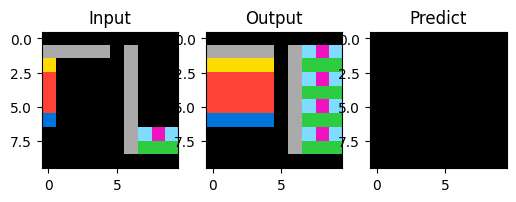

18it [00:02, 12.29it/s]

Accuracy:  0.4272959183673469


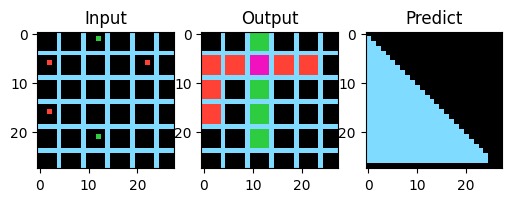

20it [00:02, 13.82it/s]

Accuracy:  0.68


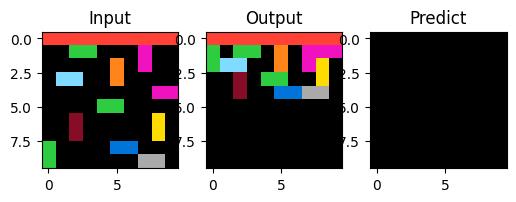

22it [00:02, 14.96it/s]

Accuracy:  0.7525925925925926


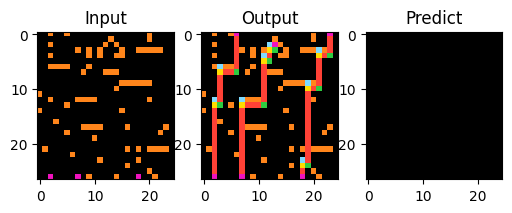

Accuracy:  0.0


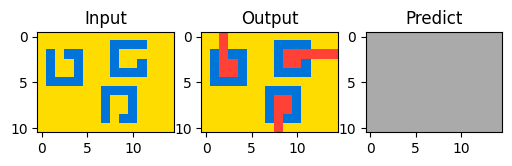

24it [00:02, 12.30it/s]

Accuracy:  0.8148148148148148


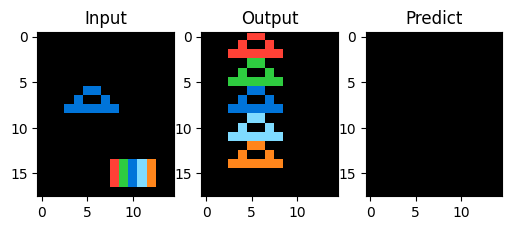

26it [00:02, 13.46it/s]

Accuracy:  0.798951048951049


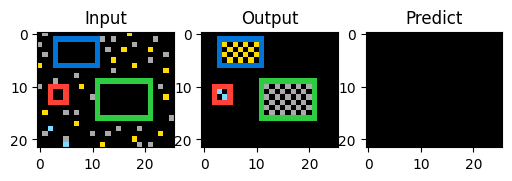

28it [00:02, 14.58it/s]

Accuracy:  0.7474747474747475


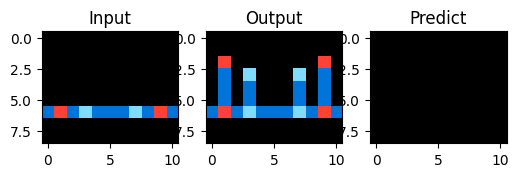

30it [00:03, 12.75it/s]

Accuracy:  0.7994505494505495


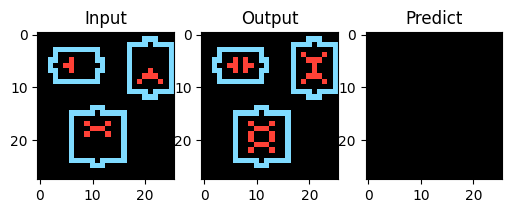

Accuracy:  0.64


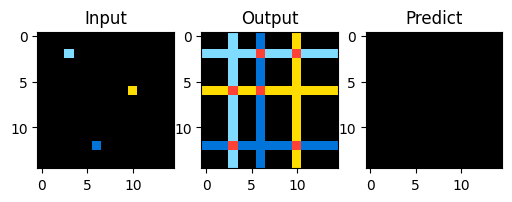

32it [00:03, 11.35it/s]

Accuracy:  0.32


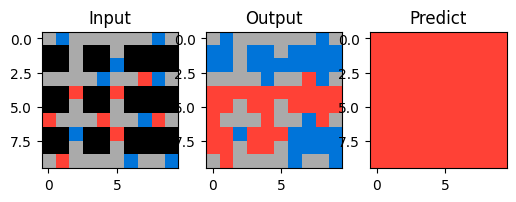

Accuracy:  0.6731301939058172


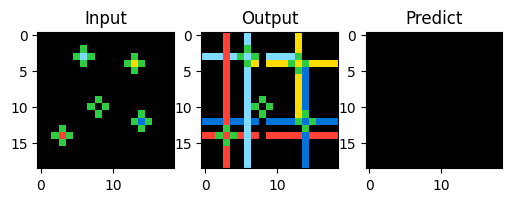

34it [00:03, 10.31it/s]

Accuracy:  0.797979797979798


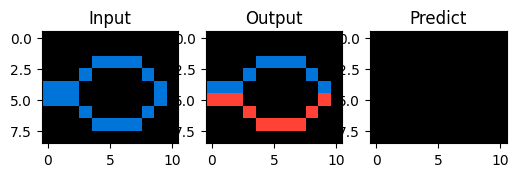

Accuracy:  0.7956730769230769


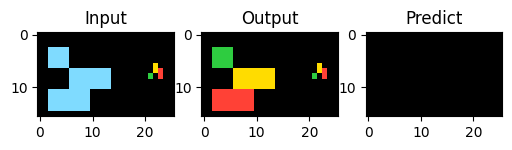

36it [00:03,  9.83it/s]

Accuracy:  0.7377622377622378


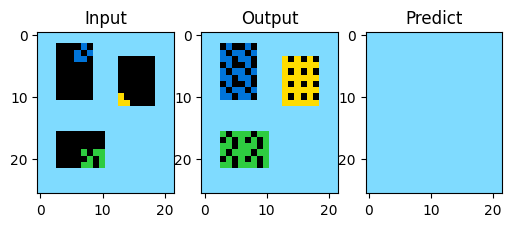

Accuracy:  0.5552913198573127


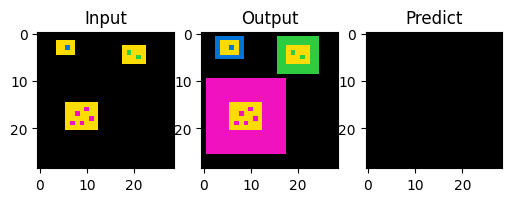

38it [00:03,  9.48it/s]

Accuracy:  0.6822660098522167


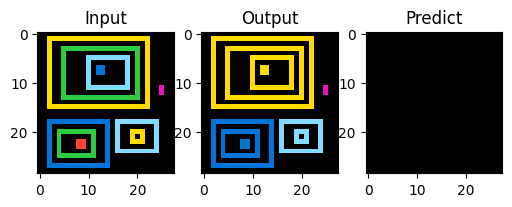

Accuracy:  0.7356902356902357


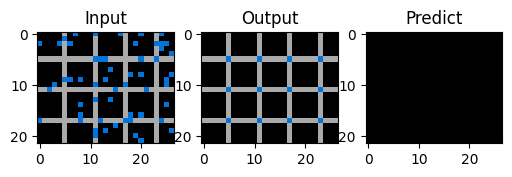

40it [00:04,  9.28it/s]

Accuracy:  0.3605263157894737


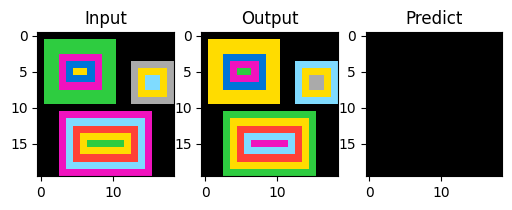

41it [00:04,  9.21it/s]

Accuracy:  0.7325


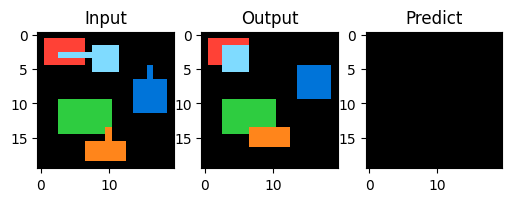

43it [00:04, 10.88it/s]

Accuracy:  0.4627450980392157


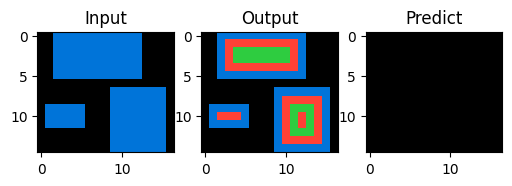

45it [00:04, 12.57it/s]

Accuracy:  0.36363636363636365


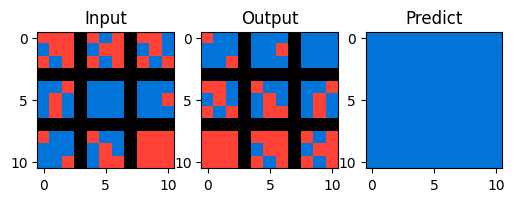

47it [00:04, 11.71it/s]

Accuracy:  0.5443786982248521


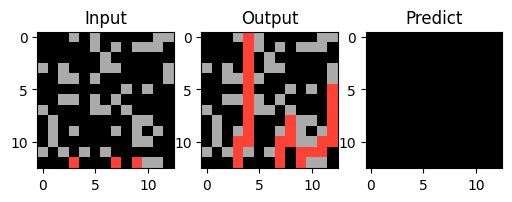

Accuracy:  0.8791208791208791


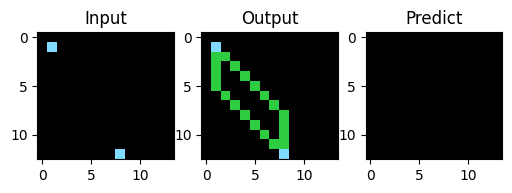

49it [00:04, 10.75it/s]

Accuracy:  0.8552036199095022


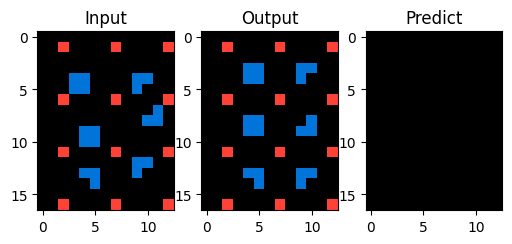

51it [00:05, 12.04it/s]

Accuracy:  0.86


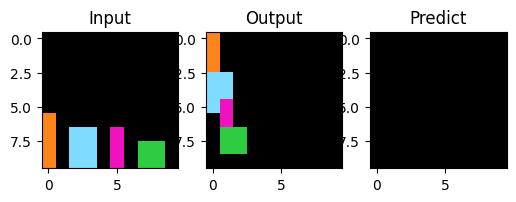

53it [00:05, 13.26it/s]

Accuracy:  0.5511111111111111


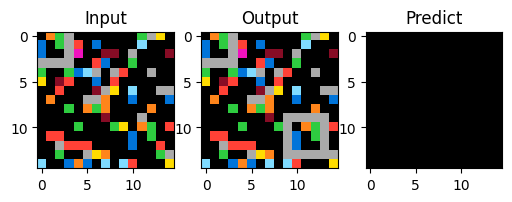

55it [00:05, 14.25it/s]

Accuracy:  0.5555555555555556


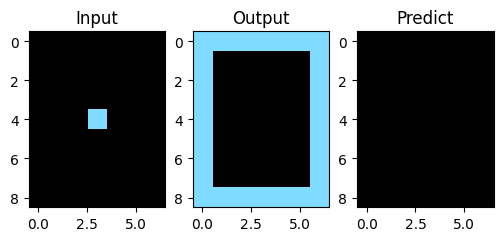

Accuracy:  0.5311111111111111


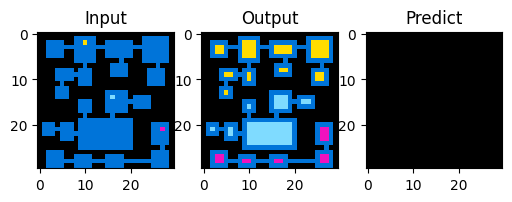

57it [00:05, 11.69it/s]

Accuracy:  0.8902606310013718


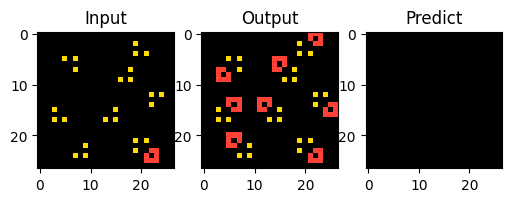

Accuracy:  0.43209876543209874


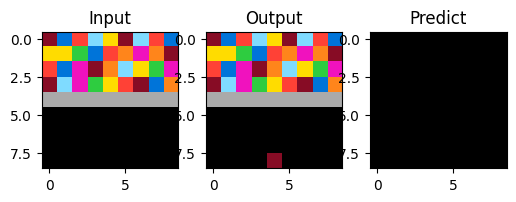

59it [00:05, 10.61it/s]

Accuracy:  0.5208333333333334


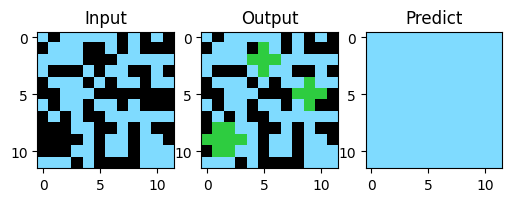

61it [00:05, 12.08it/s]

Accuracy:  0.8099173553719008


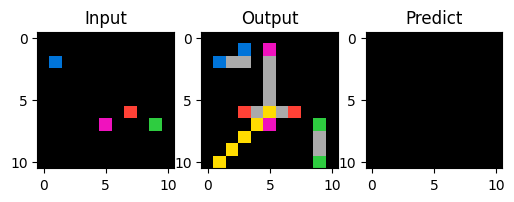

63it [00:05, 13.41it/s]

Accuracy:  0.6885813148788927


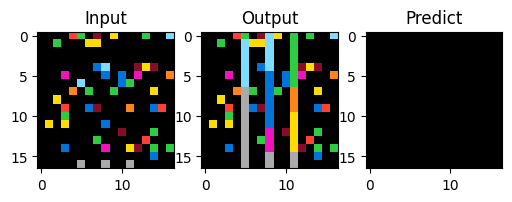

Accuracy:  0.77


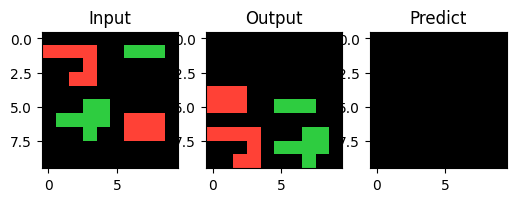

65it [00:06, 10.11it/s]

Accuracy:  0.6233766233766234


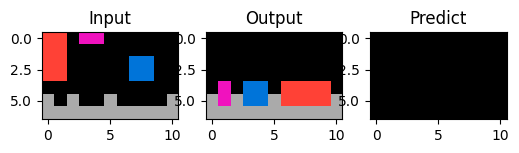

Accuracy:  0.73


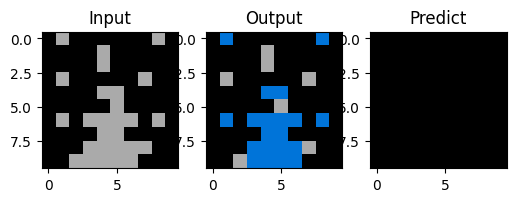

67it [00:06,  9.76it/s]

Accuracy:  0.3472222222222222


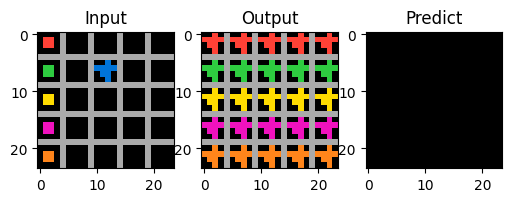

69it [00:06, 10.77it/s]

Accuracy:  0.8914473684210527


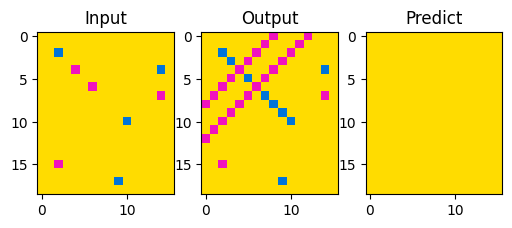

71it [00:06, 11.96it/s]

Accuracy:  0.9173553719008265


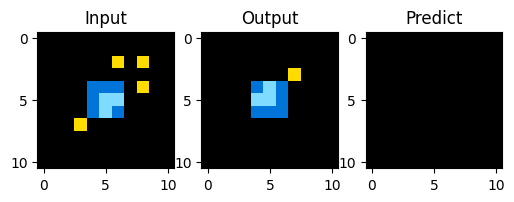

Accuracy:  0.0


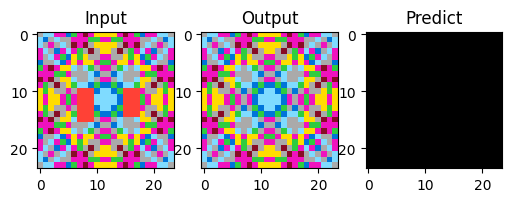

73it [00:07, 10.75it/s]

Accuracy:  0.6666666666666666


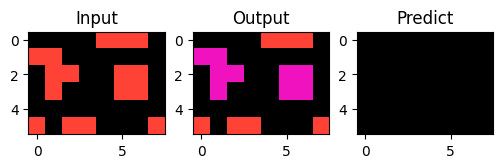

75it [00:07, 12.33it/s]

Accuracy:  0.04142011834319527


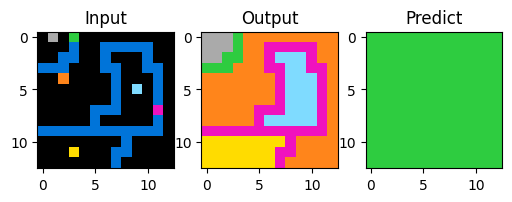

77it [00:07, 13.53it/s]

Accuracy:  0.7142857142857143


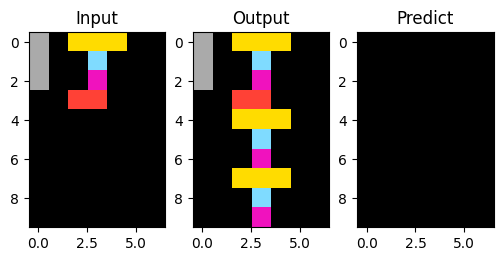

Accuracy:  0.09333333333333334


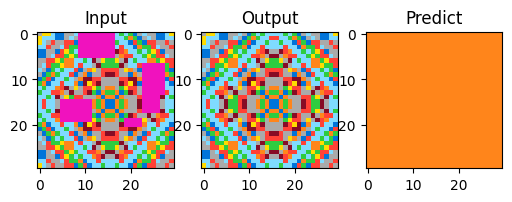

79it [00:07, 11.28it/s]

Accuracy:  0.8645833333333334


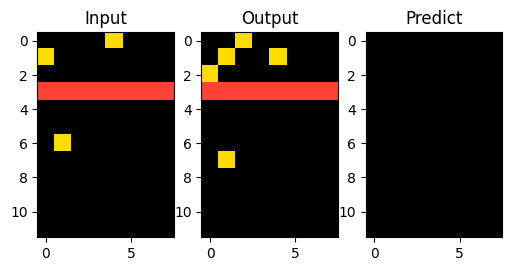

Accuracy:  0.36


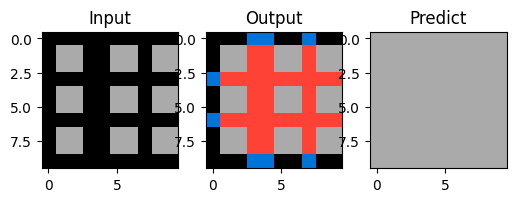

81it [00:07, 10.04it/s]

Accuracy:  0.7443181818181818


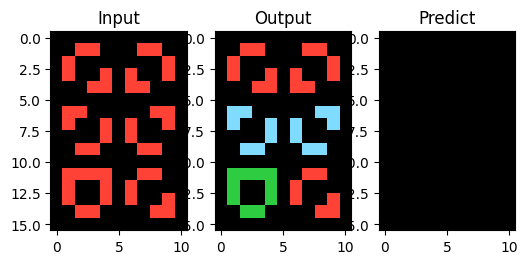

84it [00:07, 12.60it/s]

Accuracy:  0.3950617283950617


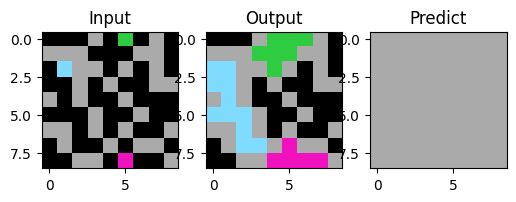

Accuracy:  0.8888888888888888


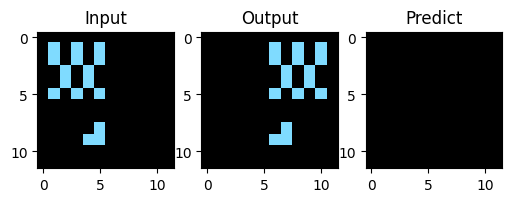

86it [00:08, 10.03it/s]

Accuracy:  0.478


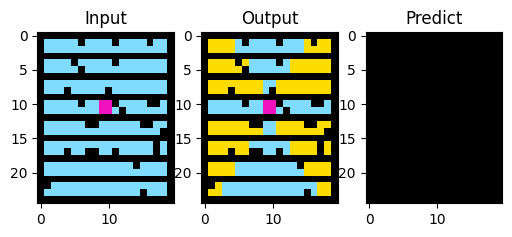

Accuracy:  0.6475


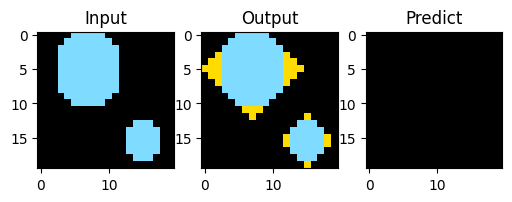

88it [00:08,  9.43it/s]

Accuracy:  0.6264090177133655


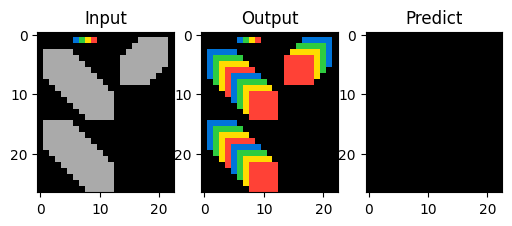

90it [00:08, 10.54it/s]

Accuracy:  0.46938775510204084


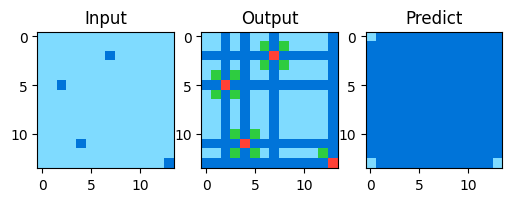

92it [00:08, 11.71it/s]

Accuracy:  0.5694444444444444


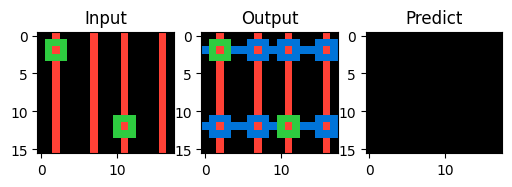

94it [00:08, 12.90it/s]

Accuracy:  0.6421404682274248


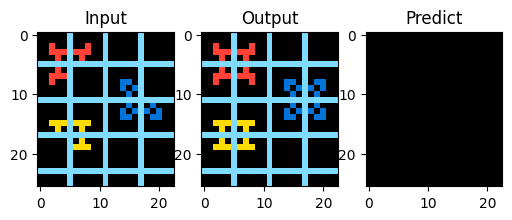

96it [00:08, 13.86it/s]

Accuracy:  0.673469387755102


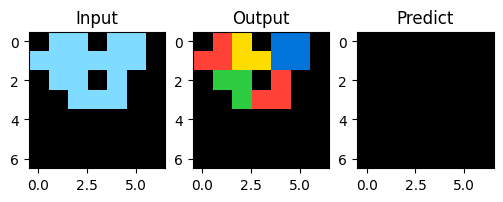

98it [00:09, 14.55it/s]

Accuracy:  0.8888888888888888


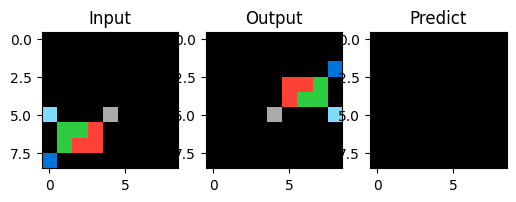

Accuracy:  0.7291666666666666


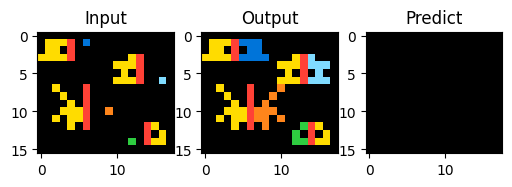

100it [00:09, 12.06it/s]

Accuracy:  0.75


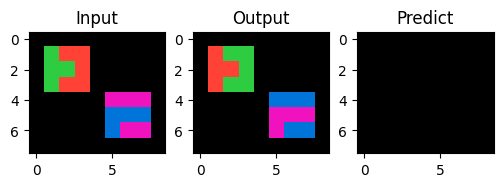

102it [00:09, 13.07it/s]

Accuracy:  0.7229916897506925


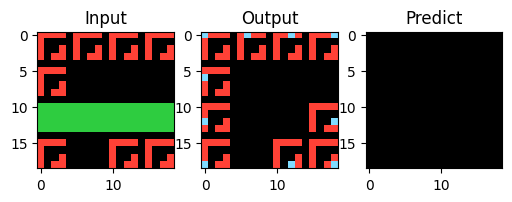

105it [00:09, 15.80it/s]

Accuracy:  0.43


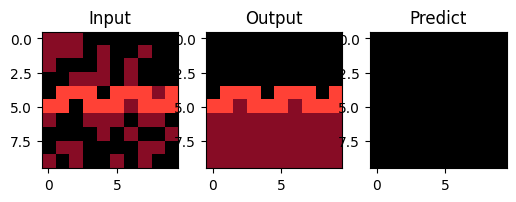

Accuracy:  0.7346938775510204


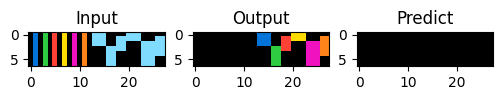

107it [00:09, 11.53it/s]

Accuracy:  0.83


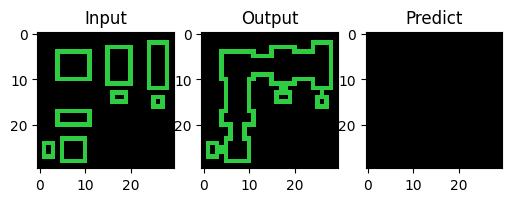

Accuracy:  0.73


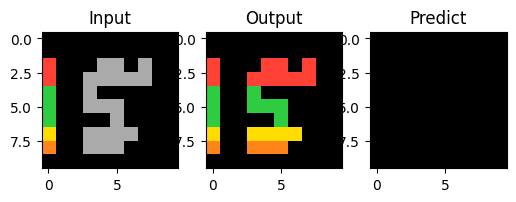

109it [00:10, 10.51it/s]

Accuracy:  0.22


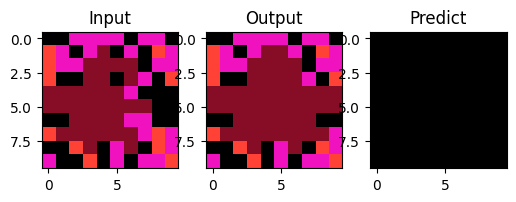

111it [00:10, 11.81it/s]

Accuracy:  0.41435185185185186


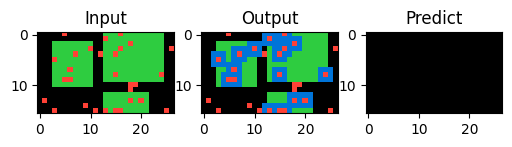

115it [00:10, 17.00it/s]

Accuracy:  0.7987012987012987


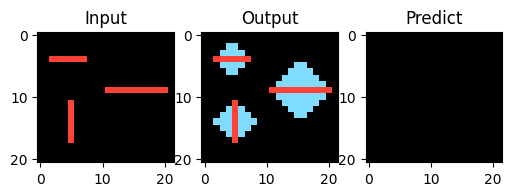

120it [00:10, 23.24it/s]

Accuracy:  0.8533333333333334


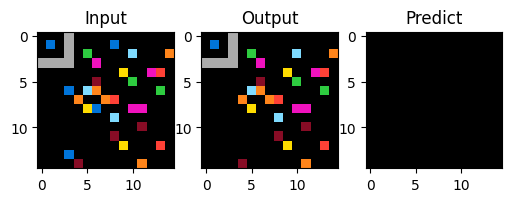

Accuracy:  0.0


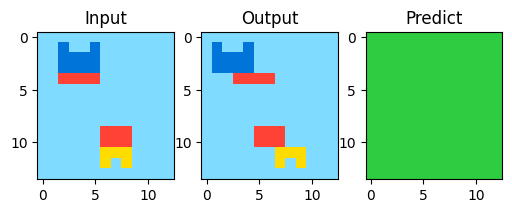

Accuracy:  0.9080459770114943


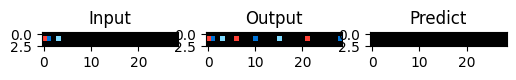

123it [00:10, 16.16it/s]

Accuracy:  0.75


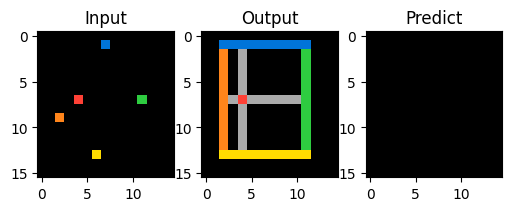

Accuracy:  0.43703703703703706


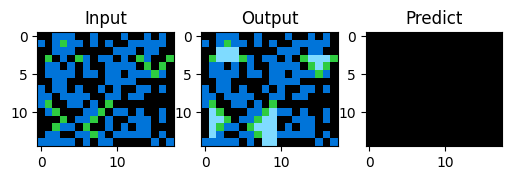

126it [00:11, 14.48it/s]

Accuracy:  0.3767313019390582


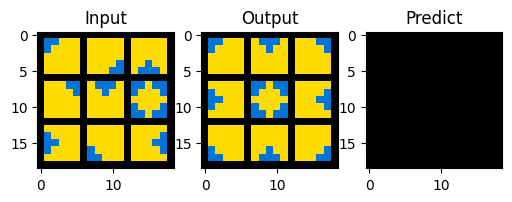

Accuracy:  0.8673469387755102


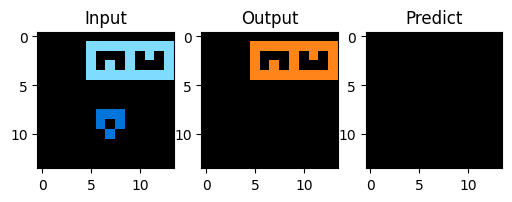

128it [00:11, 12.66it/s]

Accuracy:  0.64


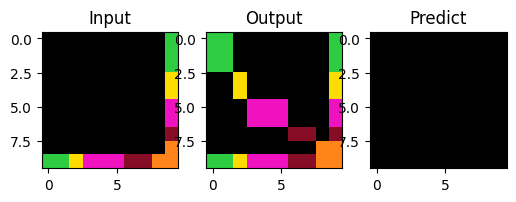

Accuracy:  0.8823529411764706


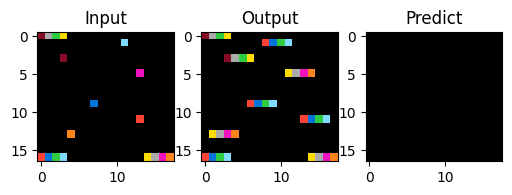

130it [00:11, 10.28it/s]

Accuracy:  0.49166666666666664


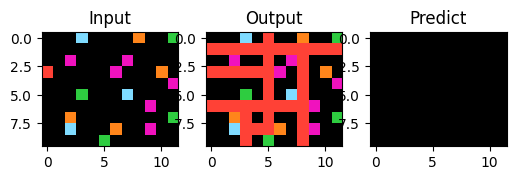

Accuracy:  0.9583333333333334


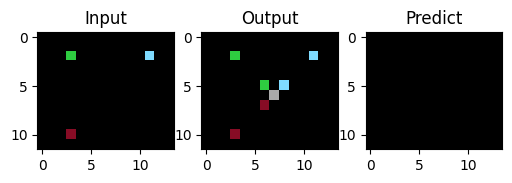

132it [00:11,  9.65it/s]

Accuracy:  0.42


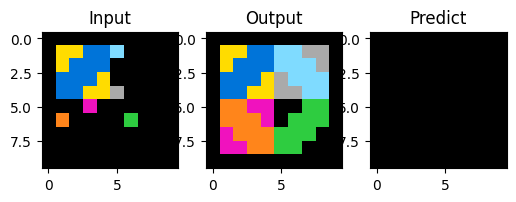

134it [00:11, 10.73it/s]

Accuracy:  0.32142857142857145


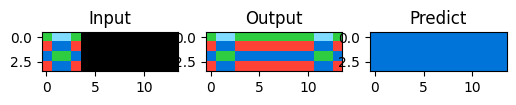

136it [00:12, 11.96it/s]

Accuracy:  0.2551440329218107


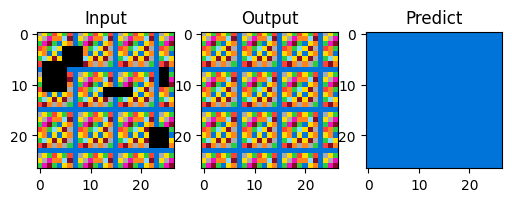

Accuracy:  0.7851458885941645


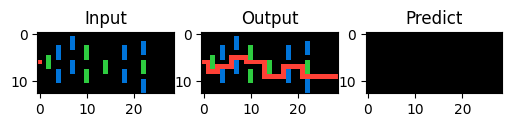

138it [00:12, 10.12it/s]

Accuracy:  0.3888888888888889


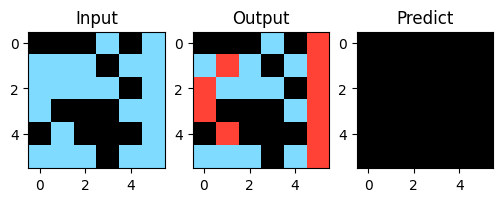

140it [00:12, 10.90it/s]

Accuracy:  0.82


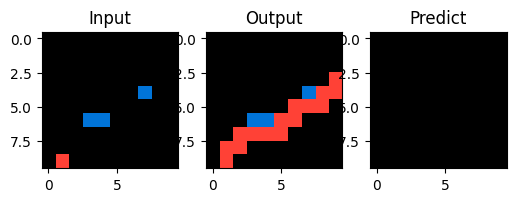

Accuracy:  0.8012820512820513


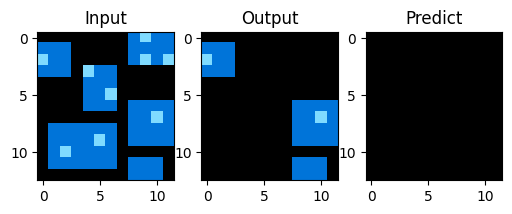

142it [00:12,  8.75it/s]

Accuracy:  0.4463667820069204


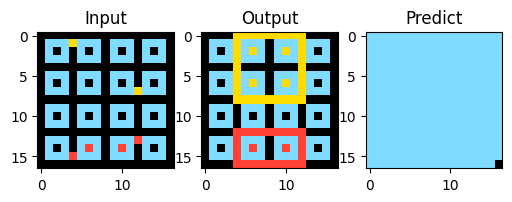

Accuracy:  0.545


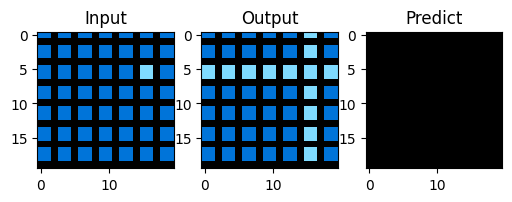

144it [00:13,  7.92it/s]

Accuracy:  0.40828402366863903


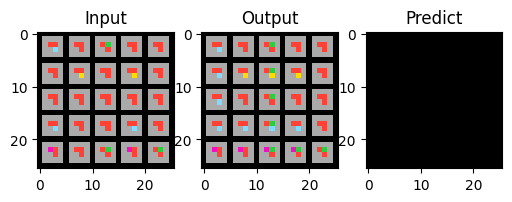

145it [00:13,  7.70it/s]

Accuracy:  0.92


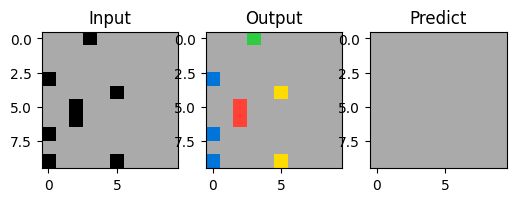

146it [00:13,  6.47it/s]

Accuracy:  0.40350877192982454


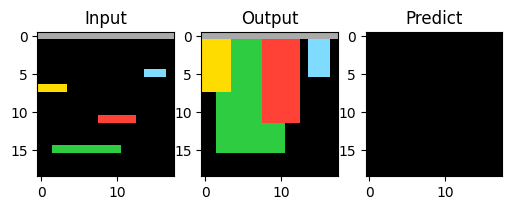

147it [00:13,  6.51it/s]

Accuracy:  0.4855555555555556


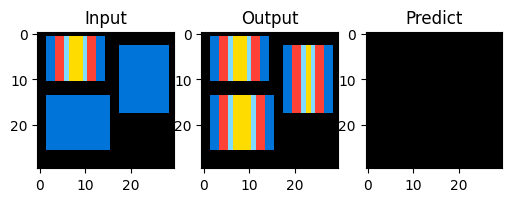

149it [00:13,  8.12it/s]

Accuracy:  0.5


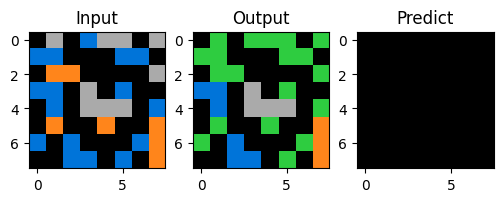

150it [00:13,  7.74it/s]

Accuracy:  0.6363636363636364


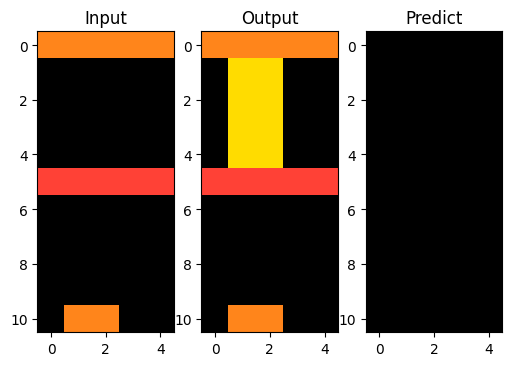

151it [00:14,  7.04it/s]

Accuracy:  0.9777777777777777


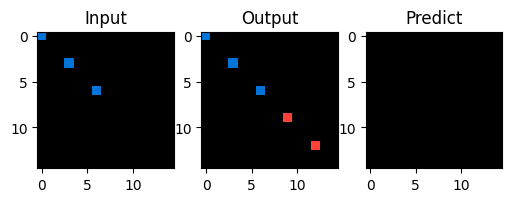

153it [00:14,  8.59it/s]

Accuracy:  0.5666666666666667


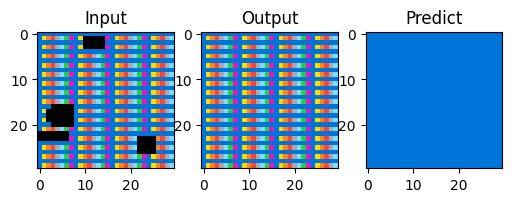

154it [00:14,  7.89it/s]

Accuracy:  0.6011080332409973


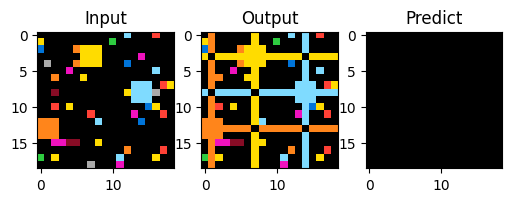

155it [00:14,  7.48it/s]

Accuracy:  0.553875236294896


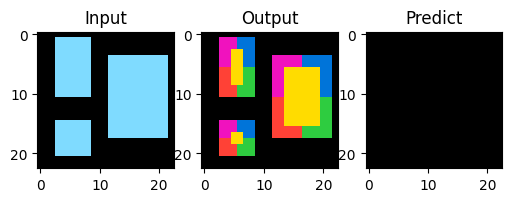

156it [00:14,  7.00it/s]

Accuracy:  0.36813186813186816


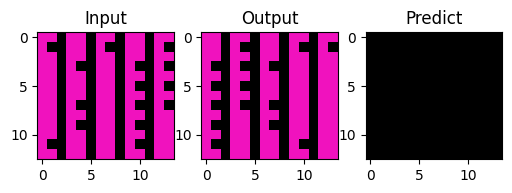

157it [00:14,  6.88it/s]

Accuracy:  0.5488165680473372


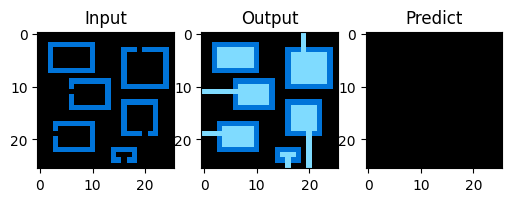

158it [00:15,  6.79it/s]

Accuracy:  0.8733031674208145


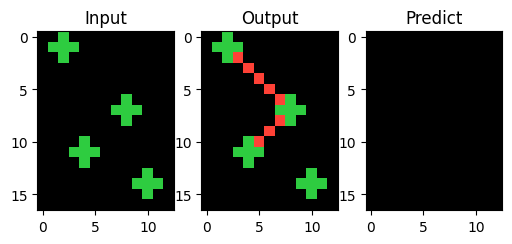

159it [00:15,  6.22it/s]

Accuracy:  0.5555555555555556


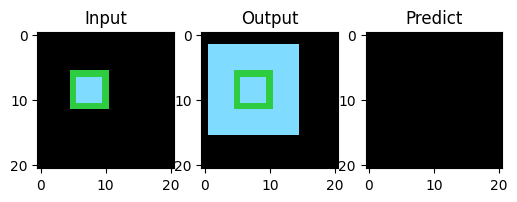

161it [00:15,  7.88it/s]

Accuracy:  0.23863636363636365


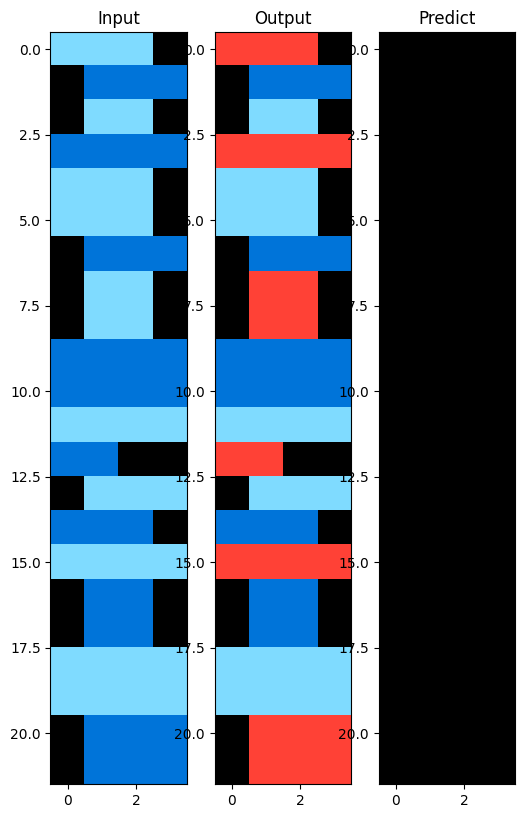

162it [00:15,  5.47it/s]

Accuracy:  0.2997448979591837


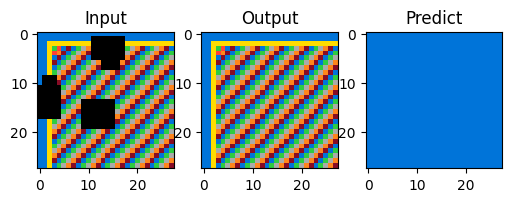

163it [00:15,  5.77it/s]

Accuracy:  0.49523809523809526


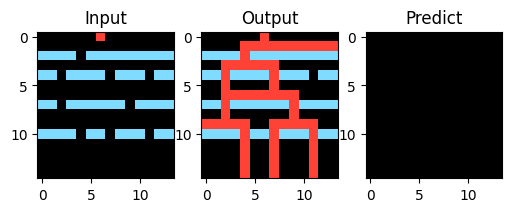

164it [00:16,  6.02it/s]

Accuracy:  0.0


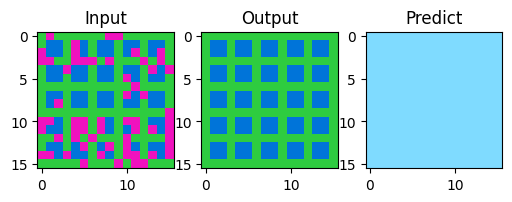

165it [00:16,  6.21it/s]

Accuracy:  0.8055555555555556


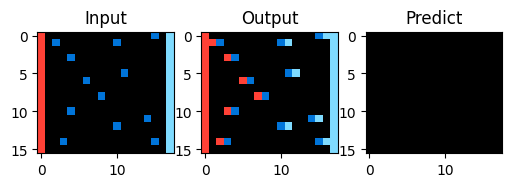

166it [00:16,  6.37it/s]

Accuracy:  0.8352272727272727


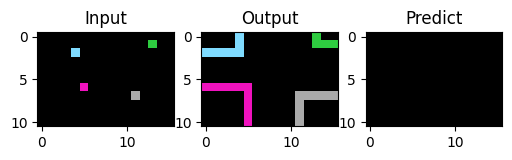

167it [00:16,  6.59it/s]

Accuracy:  0.6


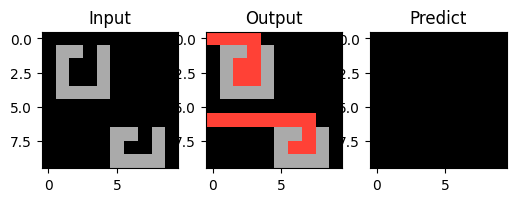

172it [00:16, 14.34it/s]

Accuracy:  0.8677685950413223


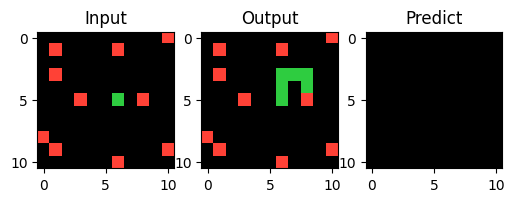

174it [00:16, 13.06it/s]

Accuracy:  0.28


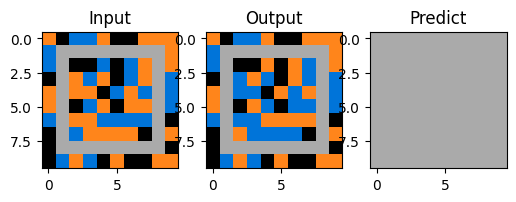

Accuracy:  0.8


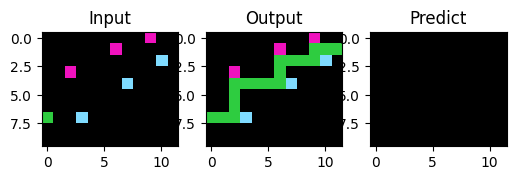

176it [00:17, 10.05it/s]

Accuracy:  0.6942148760330579


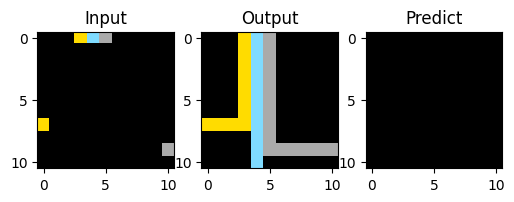

Accuracy:  0.33518005540166207


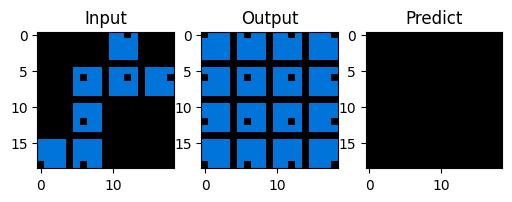

178it [00:17,  8.55it/s]

Accuracy:  0.3888888888888889


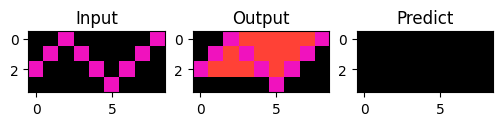

180it [00:17,  9.86it/s]

Accuracy:  0.7222222222222222


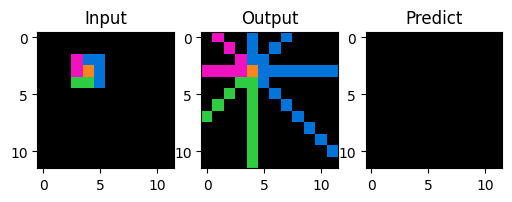

Accuracy:  0.796875


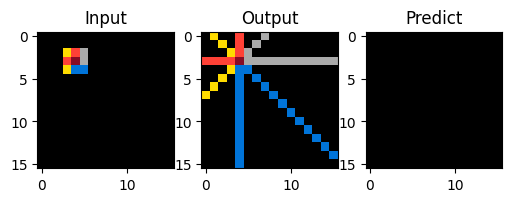

185it [00:18, 11.14it/s]

Accuracy:  0.3741496598639456


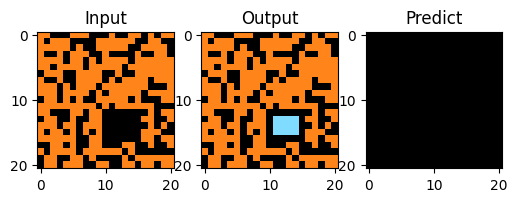

Accuracy:  0.8579881656804734


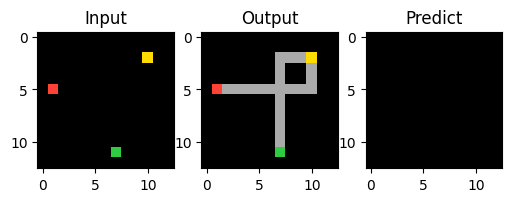

187it [00:18,  9.77it/s]

Accuracy:  0.8641975308641975


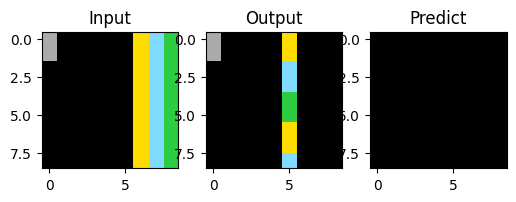

190it [00:18, 11.73it/s]

Accuracy:  0.8441558441558441


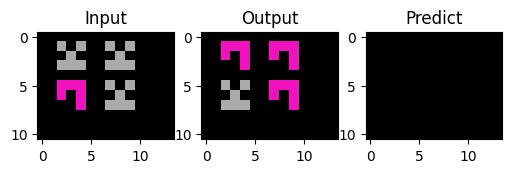

193it [00:18, 13.62it/s]

Accuracy:  0.893491124260355


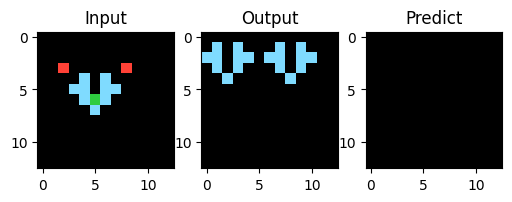

Accuracy:  0.52


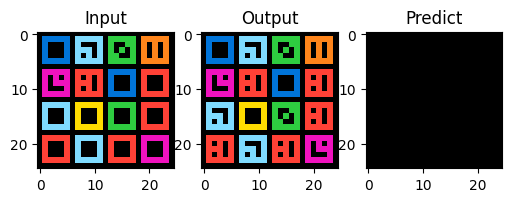

195it [00:18, 11.07it/s]

Accuracy:  0.9135802469135802


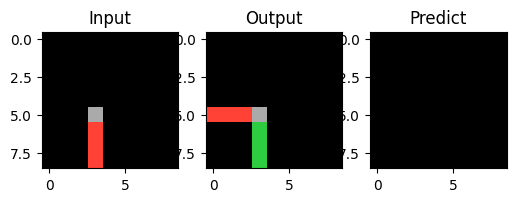

Accuracy:  0.9090909090909091


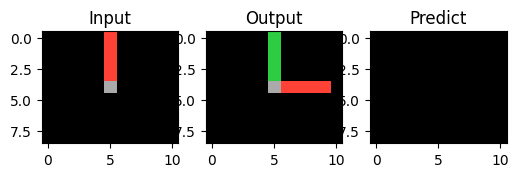

Accuracy:  0.6370370370370371


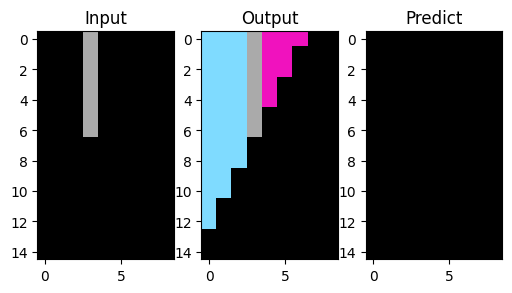

197it [00:19,  7.75it/s]

Accuracy:  0.75


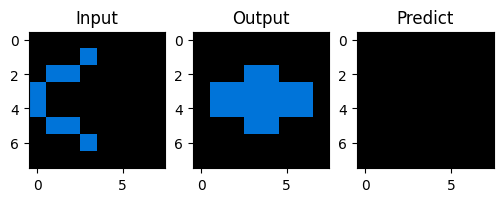

199it [00:19,  8.73it/s]

Accuracy:  0.8470588235294118


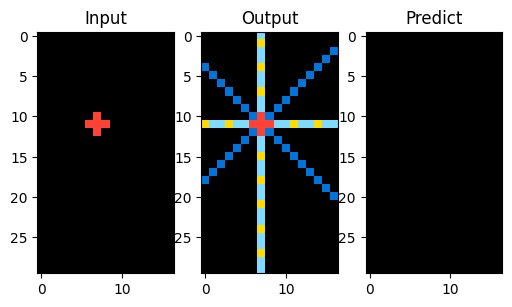

201it [00:19,  9.38it/s]

Accuracy:  0.8708791208791209


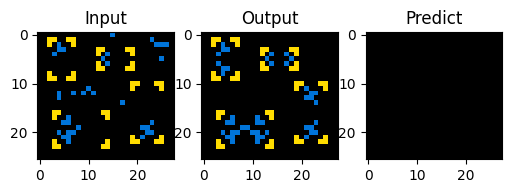

Accuracy:  0.7911111111111111


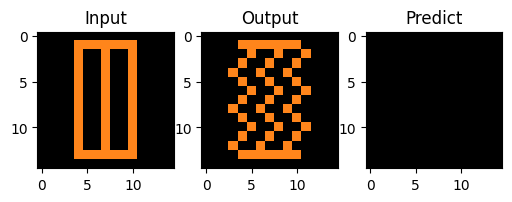

203it [00:20,  7.63it/s]

Accuracy:  0.8949579831932774


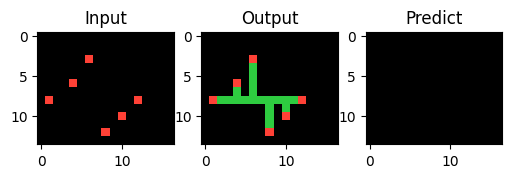

204it [00:20,  7.57it/s]

Accuracy:  0.703601108033241


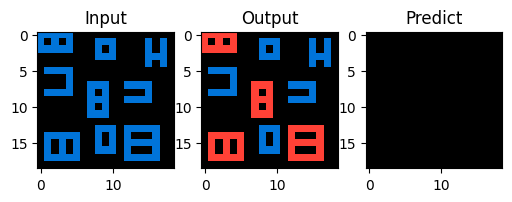

206it [00:20,  8.81it/s]

Accuracy:  0.6066666666666667


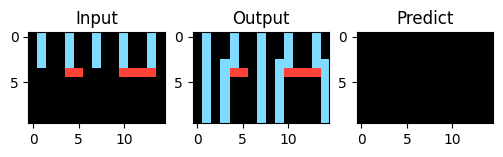

Accuracy:  0.7514792899408284


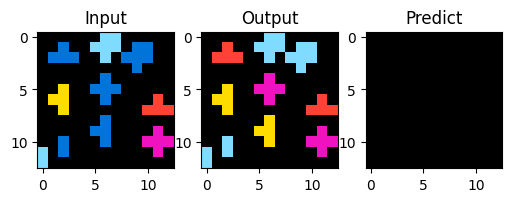

208it [00:20,  8.17it/s]

Accuracy:  0.8043478260869565


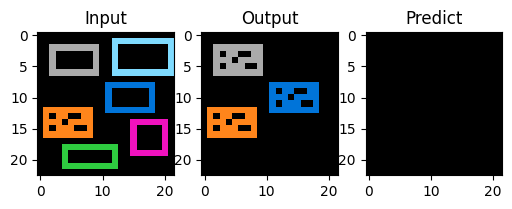

209it [00:20,  7.66it/s]

Accuracy:  0.2791666666666667


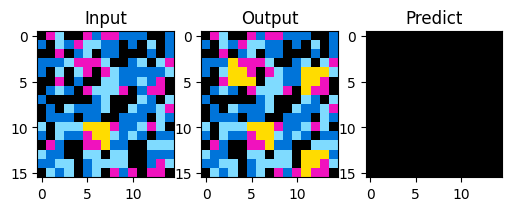

213it [00:21, 11.97it/s]

Accuracy:  0.08333333333333333


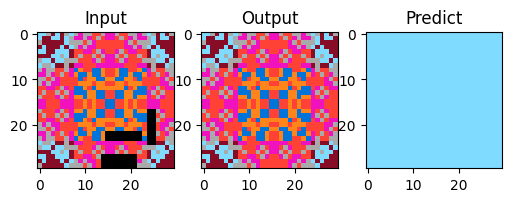

215it [00:21, 12.28it/s]

Accuracy:  0.625


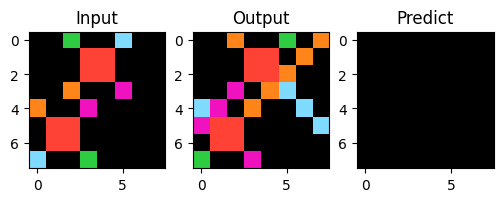

218it [00:21, 14.36it/s]

Accuracy:  0.8671875


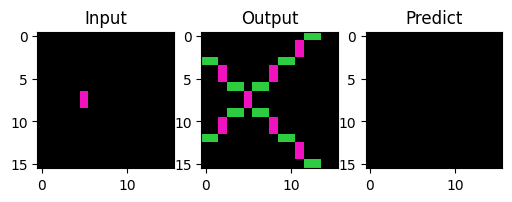

220it [00:21, 14.08it/s]

Accuracy:  0.47474747474747475


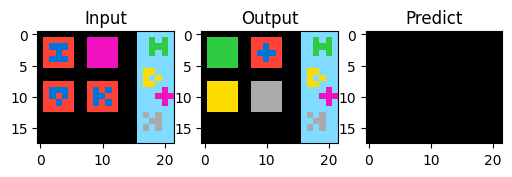

224it [00:21, 17.51it/s]

Accuracy:  0.8571428571428571


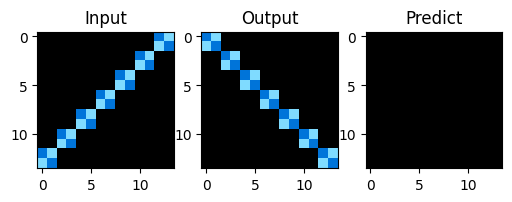

226it [00:21, 16.43it/s]

Accuracy:  0.8878205128205128


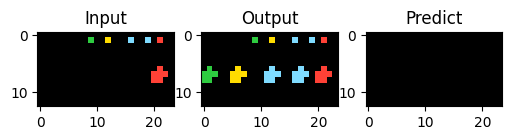

Accuracy:  0.23444444444444446


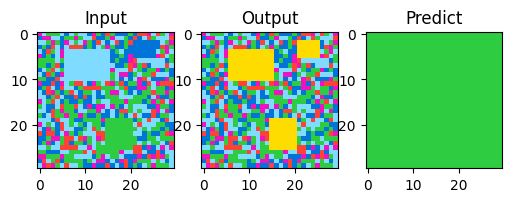

228it [00:22, 10.69it/s]

Accuracy:  0.9021739130434783


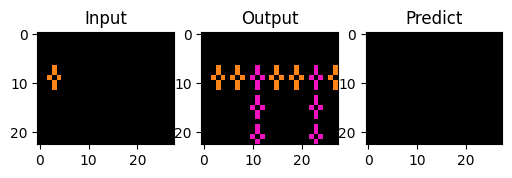

231it [00:22, 12.88it/s]

Accuracy:  0.52


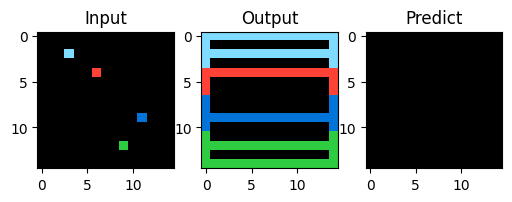

Accuracy:  0.5725


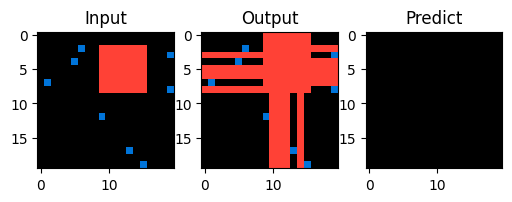

233it [00:22, 10.48it/s]

Accuracy:  0.43636363636363634


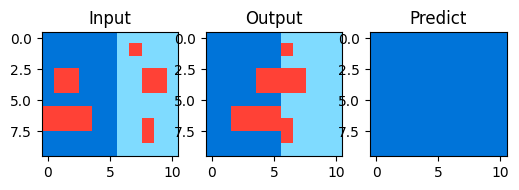

Accuracy:  0.4074074074074074


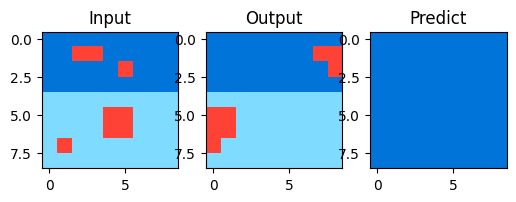

235it [00:22,  9.11it/s]

Accuracy:  0.5111111111111111


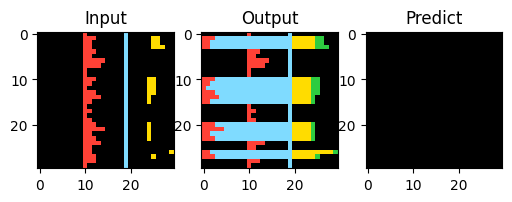

Accuracy:  0.7177033492822966


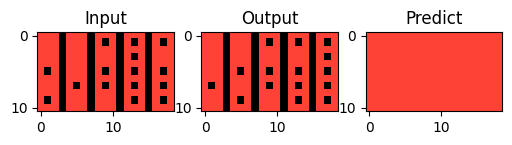

237it [00:23,  8.33it/s]

Accuracy:  0.71875


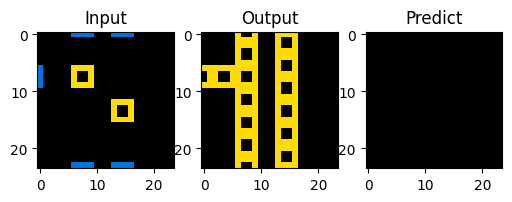

238it [00:23,  8.06it/s]

Accuracy:  0.7333333333333333


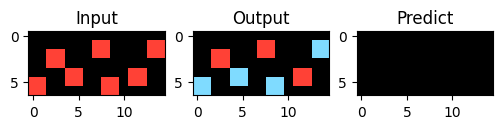

239it [00:23,  7.95it/s]

Accuracy:  0.5096952908587258


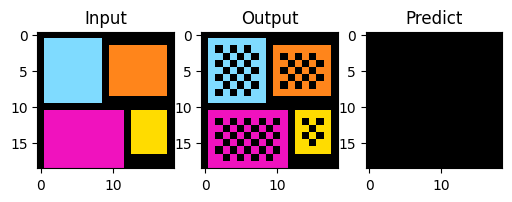

240it [00:23,  7.64it/s]

Accuracy:  0.6995614035087719


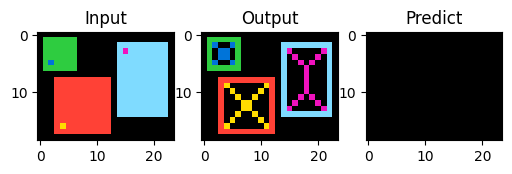

242it [00:23,  9.02it/s]

Accuracy:  0.7777777777777778


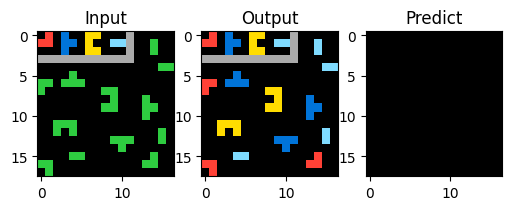

243it [00:23,  8.38it/s]

Accuracy:  0.20041322314049587


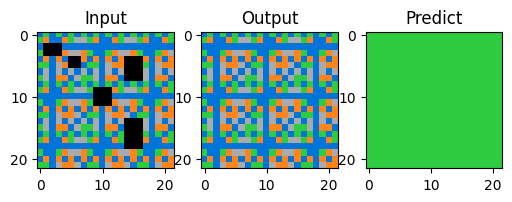

245it [00:24,  9.73it/s]

Accuracy:  0.3


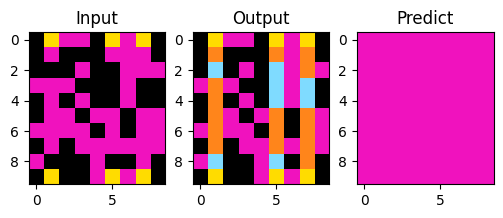

248it [00:24, 10.52it/s]

Accuracy:  0.36


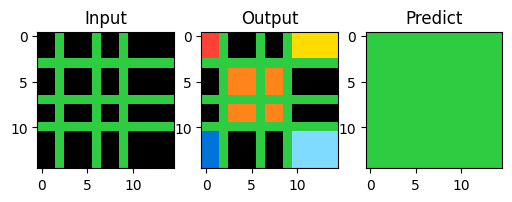

250it [00:24, 11.29it/s]

Accuracy:  0.8675


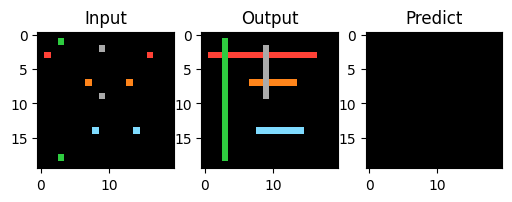

Accuracy:  0.2916666666666667


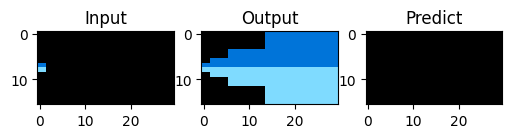

252it [00:24,  9.41it/s]

Accuracy:  0.74


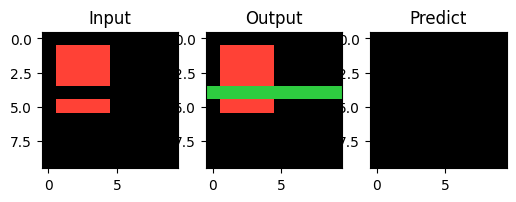

Accuracy:  0.78


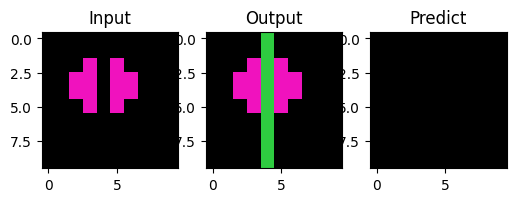

254it [00:25,  8.38it/s]

Accuracy:  0.673469387755102


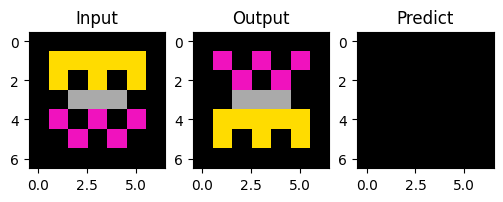

Accuracy:  0.676923076923077


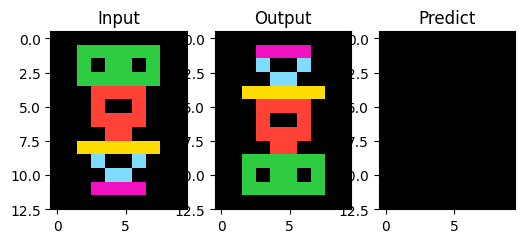

255it [00:25,  6.45it/s]

Accuracy:  0.6775147928994083


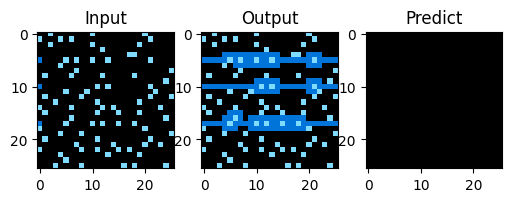

256it [00:25,  6.56it/s]

Accuracy:  0.4722222222222222


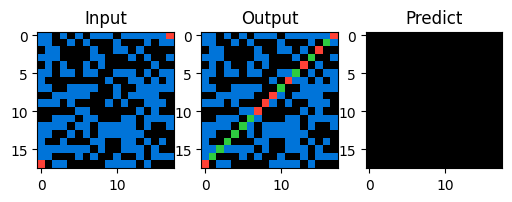

259it [00:25,  9.71it/s]

Accuracy:  0.66


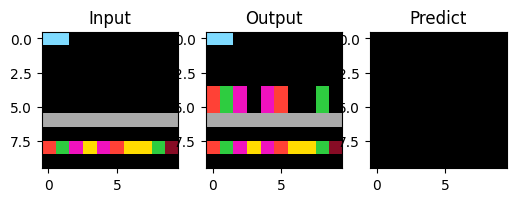

Accuracy:  0.8063241106719368


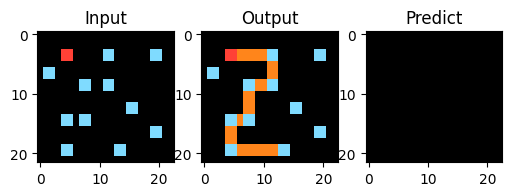

261it [00:25,  8.76it/s]

Accuracy:  0.6428571428571429


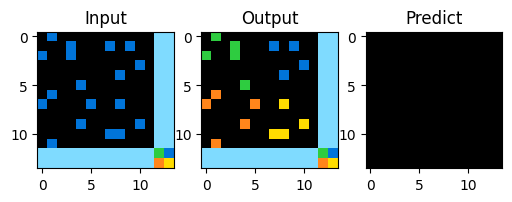

Accuracy:  0.387523629489603


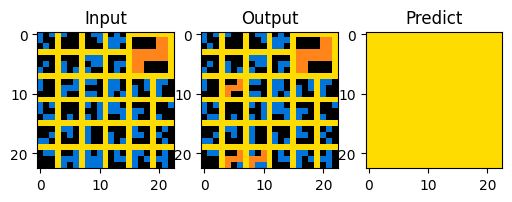

263it [00:26,  7.61it/s]

Accuracy:  0.94


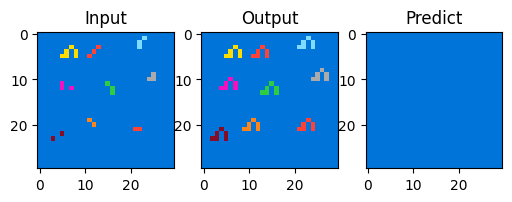

267it [00:26, 11.79it/s]

Accuracy:  0.78125


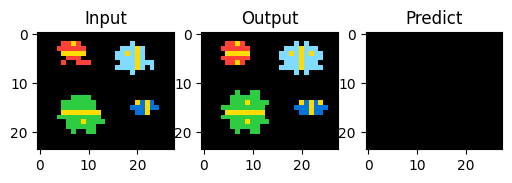

Accuracy:  0.7027863777089783


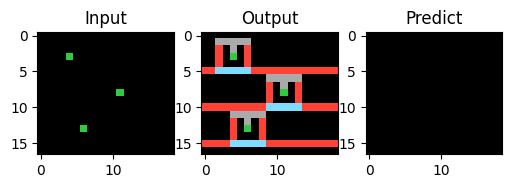

269it [00:26, 10.41it/s]

Accuracy:  0.94921875


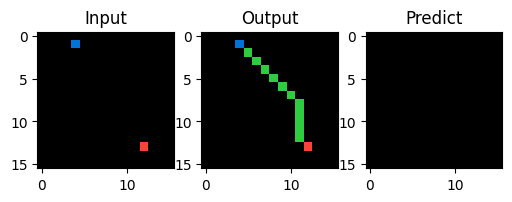

Accuracy:  0.5904


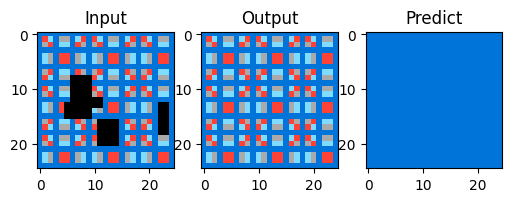

271it [00:26,  9.61it/s]

Accuracy:  0.58


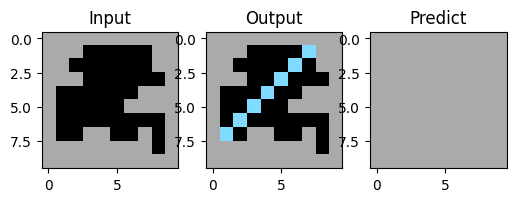

Accuracy:  0.7244444444444444


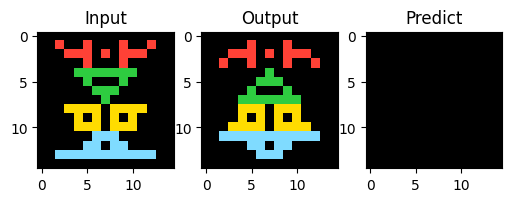

273it [00:27,  9.06it/s]

Accuracy:  0.5560897435897436


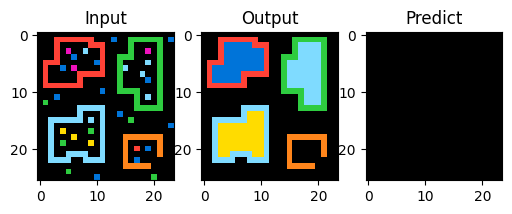

Accuracy:  0.26


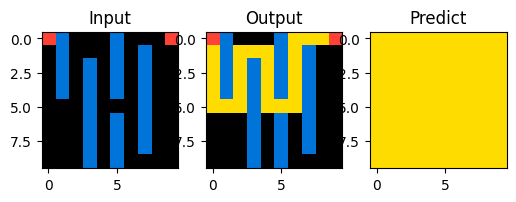

275it [00:27,  8.66it/s]

Accuracy:  0.5555555555555556


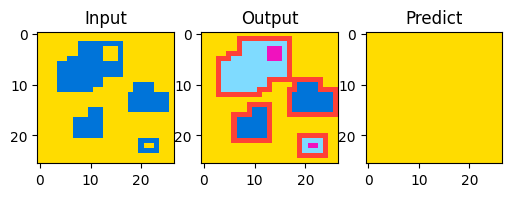

278it [00:27, 11.14it/s]

Accuracy:  0.8392857142857143


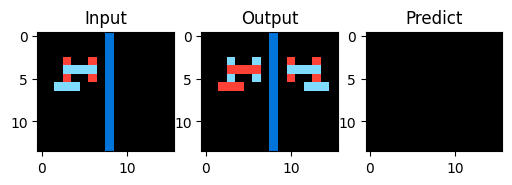

Accuracy:  0.5266272189349113


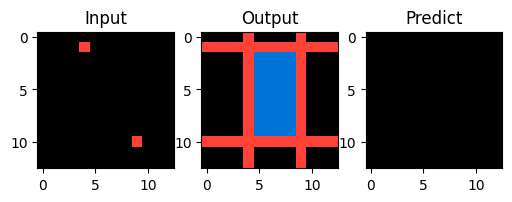

280it [00:27, 10.17it/s]

Accuracy:  0.75


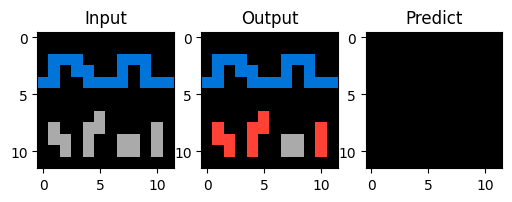

Accuracy:  0.6833333333333333


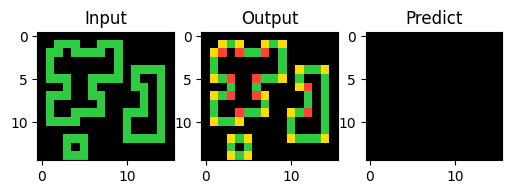

282it [00:28,  8.63it/s]

Accuracy:  0.639080459770115


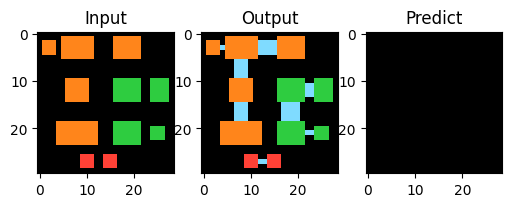

Accuracy:  0.5555555555555556


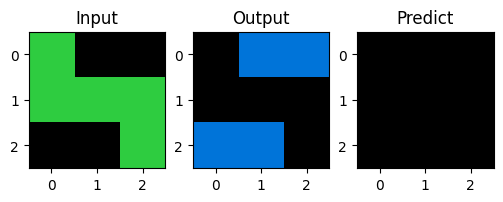

Accuracy:  0.4444444444444444


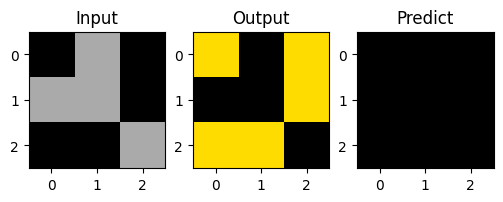

284it [00:28,  7.39it/s]

Accuracy:  0.5777777777777777


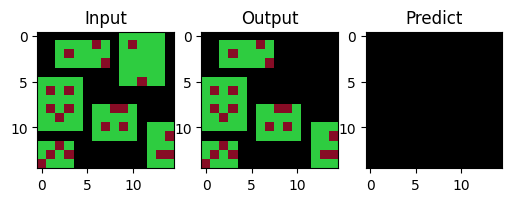

286it [00:28,  8.69it/s]

Accuracy:  0.4805194805194805


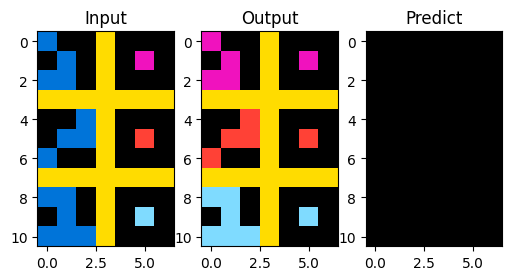

Accuracy:  0.75


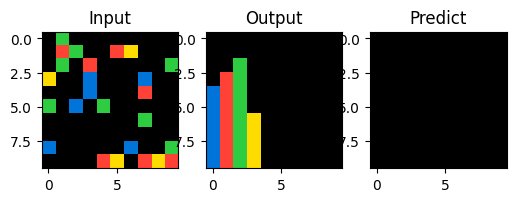

288it [00:28,  8.17it/s]

Accuracy:  0.8671328671328671


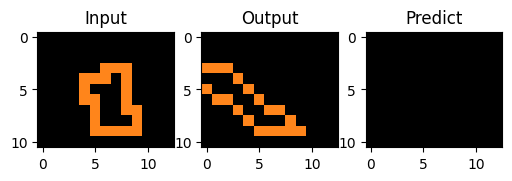

289it [00:29,  8.09it/s]

Accuracy:  0.46745562130177515


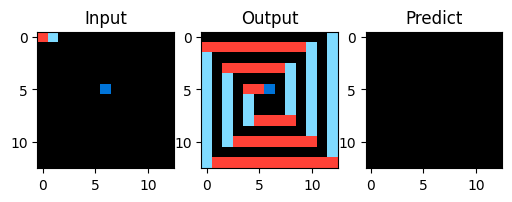

291it [00:29,  9.62it/s]

Accuracy:  0.6627450980392157


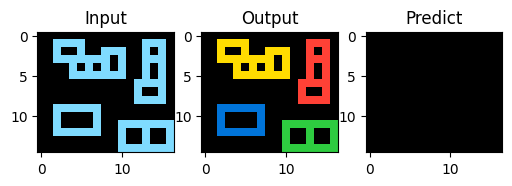

Accuracy:  0.45384615384615384


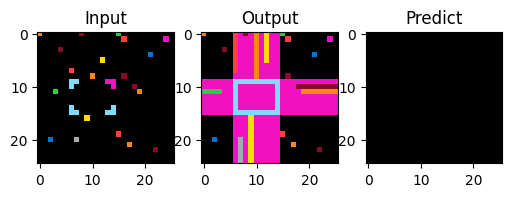

293it [00:29,  9.08it/s]

Accuracy:  0.92


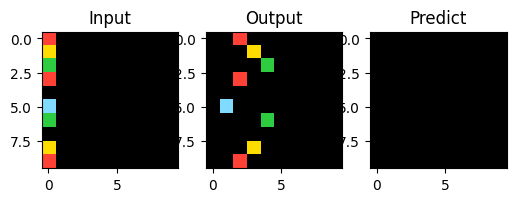

295it [00:29, 10.44it/s]

Accuracy:  0.7473684210526316


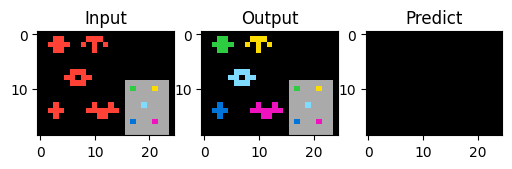

297it [00:29, 11.76it/s]

Accuracy:  0.13610586011342155


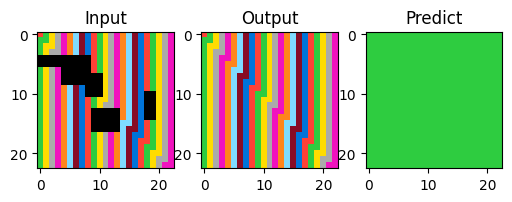

Accuracy:  0.7233333333333334


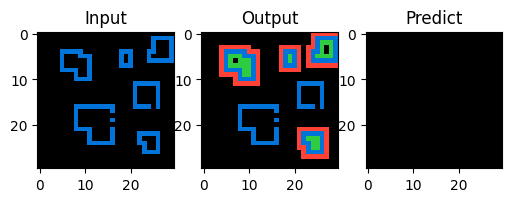

299it [00:30,  9.12it/s]

Accuracy:  0.8333333333333334


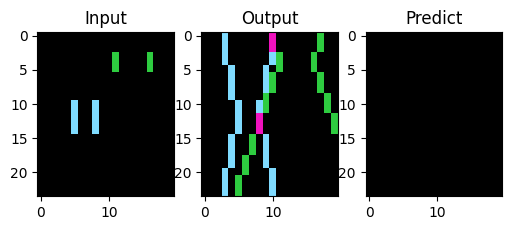

301it [00:30, 10.29it/s]

Accuracy:  0.7933884297520661


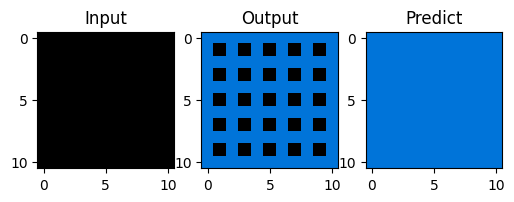

304it [00:30, 13.15it/s]

Accuracy:  0.7277777777777777


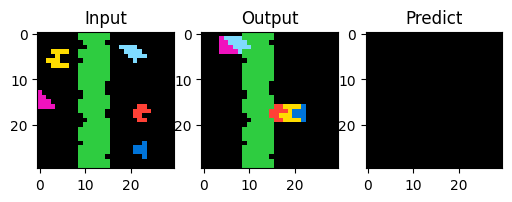

Accuracy:  0.49382716049382713


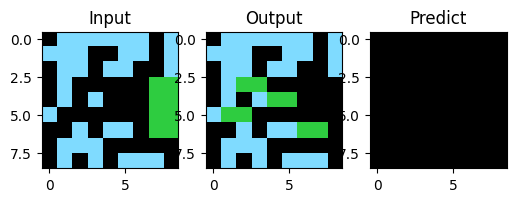

306it [00:30, 11.14it/s]

Accuracy:  0.25


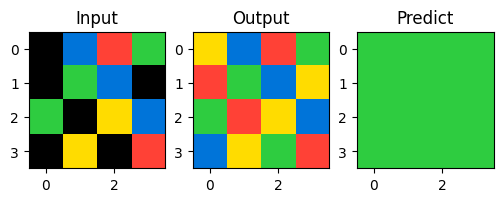

Accuracy:  0.5738636363636364


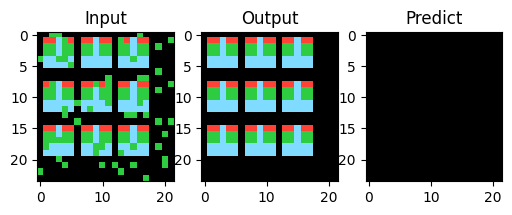

308it [00:30,  9.85it/s]

Accuracy:  0.746031746031746


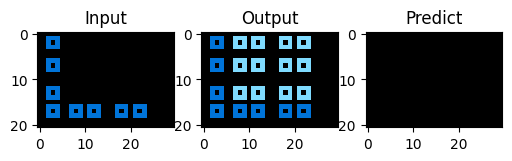

310it [00:30, 11.02it/s]

Accuracy:  0.5136741973840666


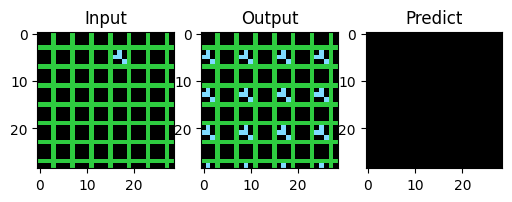

312it [00:31, 12.03it/s]

Accuracy:  0.5576923076923077


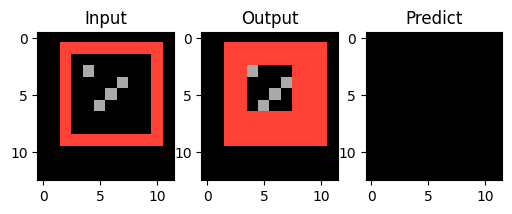

314it [00:31, 12.98it/s]

Accuracy:  0.768595041322314


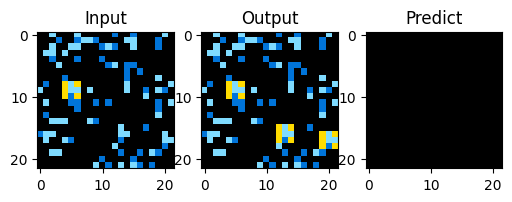

Accuracy:  0.8484848484848485


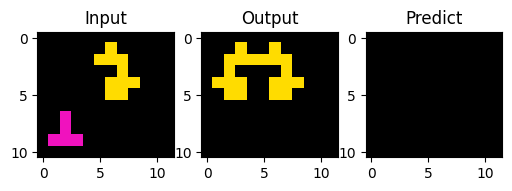

316it [00:31, 10.73it/s]

Accuracy:  0.75


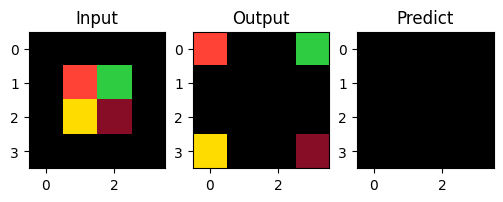

Accuracy:  0.8444444444444444


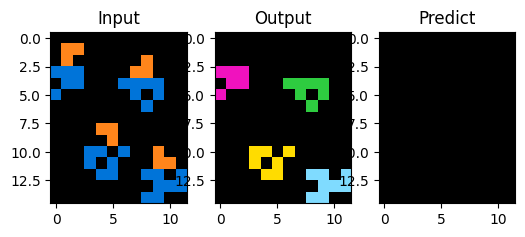

318it [00:31,  8.40it/s]

Accuracy:  0.0


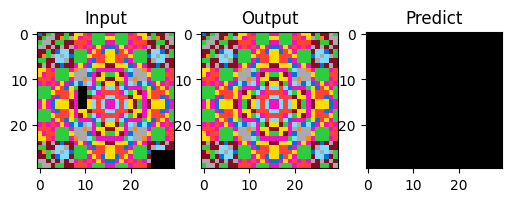

Accuracy:  0.73


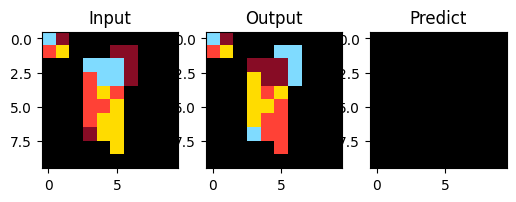

320it [00:32,  8.30it/s]

Accuracy:  0.66796875


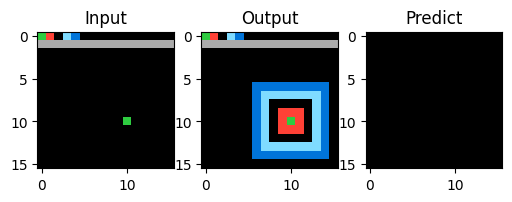

321it [00:32,  8.20it/s]

Accuracy:  0.0


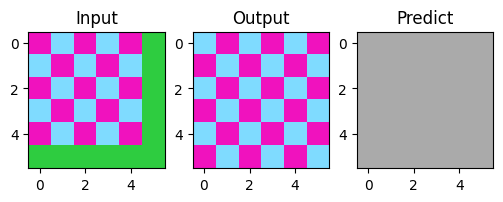

323it [00:32,  9.68it/s]

Accuracy:  0.7791666666666667


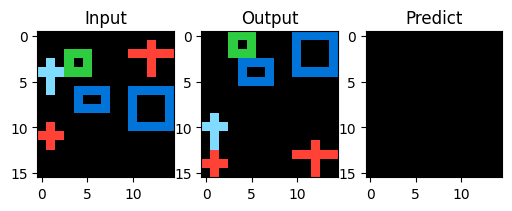

Accuracy:  0.37444444444444447


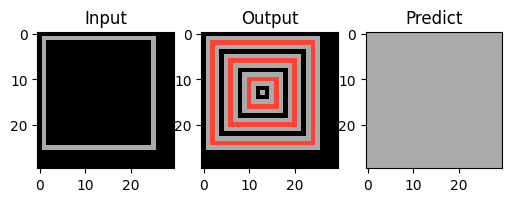

325it [00:32,  8.87it/s]

Accuracy:  0.7743271221532091


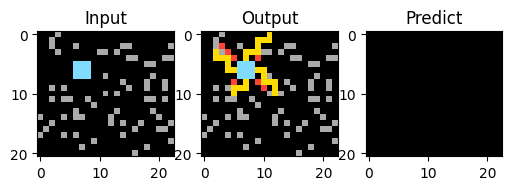

326it [00:32,  8.59it/s]

Accuracy:  0.12545454545454546


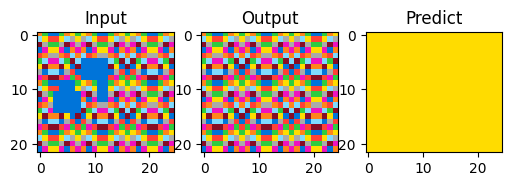

327it [00:32,  8.01it/s]

Accuracy:  0.36666666666666664


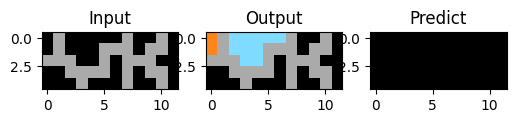

328it [00:33,  7.77it/s]

Accuracy:  0.17


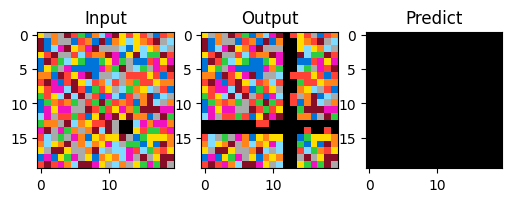

329it [00:33,  7.69it/s]

Accuracy:  0.662608695652174


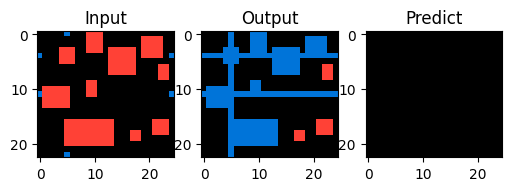

330it [00:33,  7.75it/s]

Accuracy:  0.7619047619047619


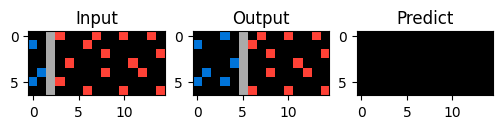

331it [00:33,  7.96it/s]

Accuracy:  0.0


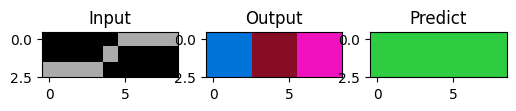

335it [00:33, 15.14it/s]

Accuracy:  0.9275


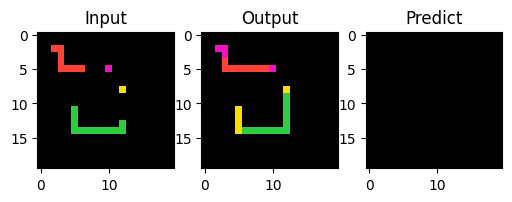

Accuracy:  0.6522222222222223


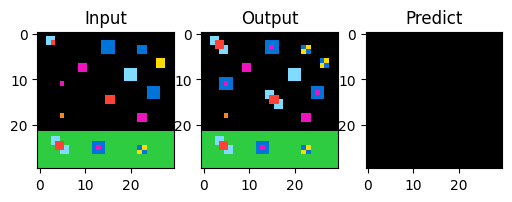

337it [00:33, 10.12it/s]

Accuracy:  0.5822222222222222


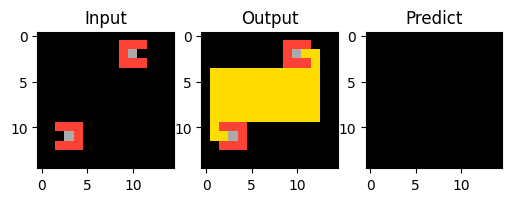

339it [00:33, 11.28it/s]

Accuracy:  0.854679802955665


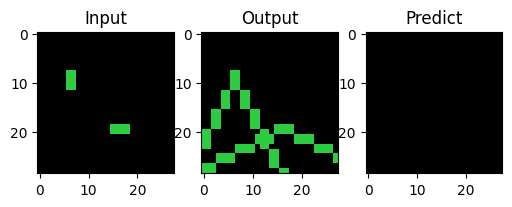

Accuracy:  0.24888888888888888


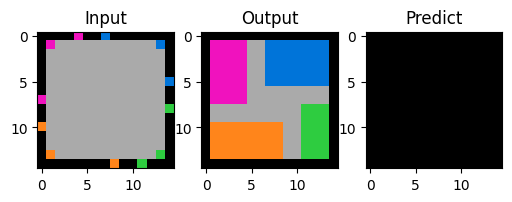

341it [00:34,  9.97it/s]

Accuracy:  0.5555555555555556


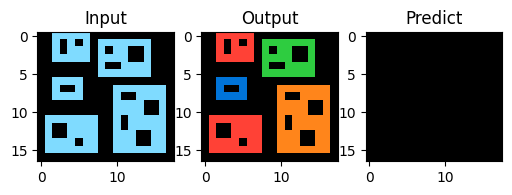

Accuracy:  0.64


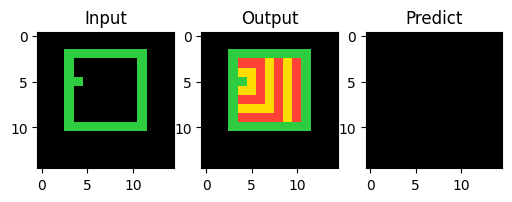

343it [00:34,  9.18it/s]

Accuracy:  0.8272727272727273


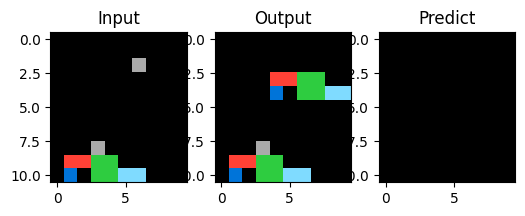

345it [00:34, 10.21it/s]

Accuracy:  0.9655555555555555


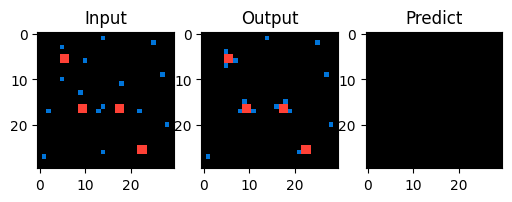

348it [00:34, 12.99it/s]

Accuracy:  0.32


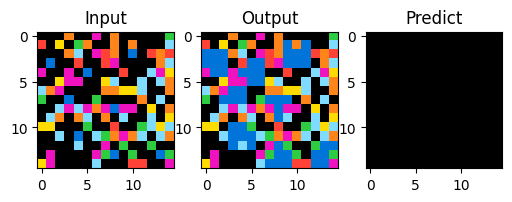

350it [00:34, 13.57it/s]

Accuracy:  0.5058823529411764


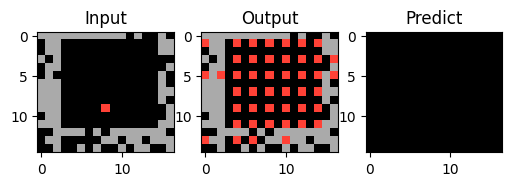

Accuracy:  0.7058823529411765


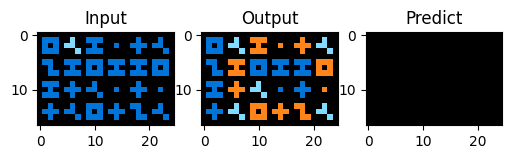

352it [00:35, 11.40it/s]

Accuracy:  0.7511111111111111


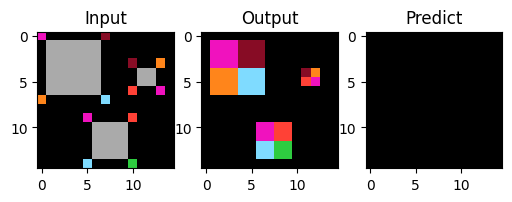

Accuracy:  0.6923076923076923


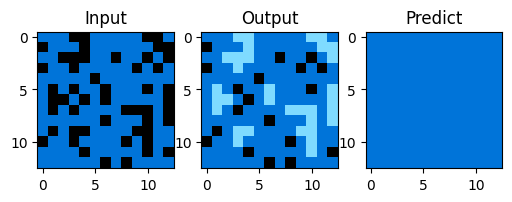

354it [00:35, 10.11it/s]

Accuracy:  0.5325


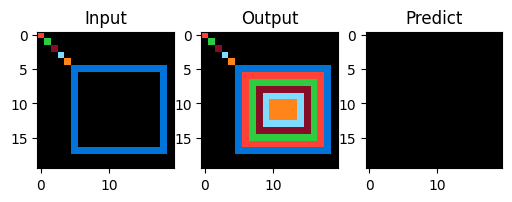

356it [00:35,  9.78it/s]

Accuracy:  0.88


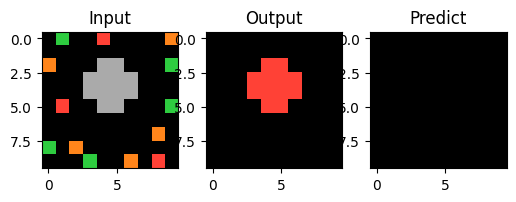

358it [00:35, 10.97it/s]

Accuracy:  0.8823529411764706


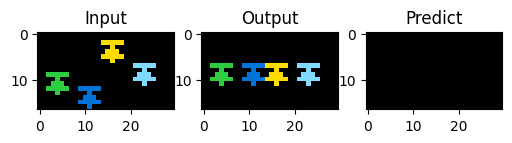

361it [00:35, 13.83it/s]

Accuracy:  0.35


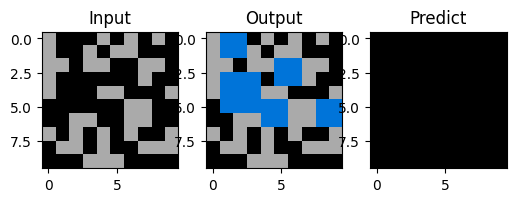

363it [00:35, 14.20it/s]

Accuracy:  0.140625


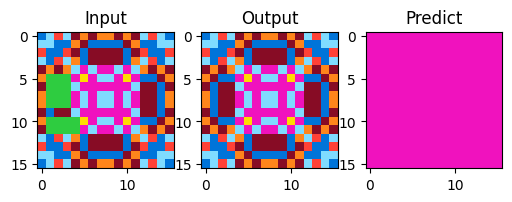

365it [00:36, 14.58it/s]

Accuracy:  0.75


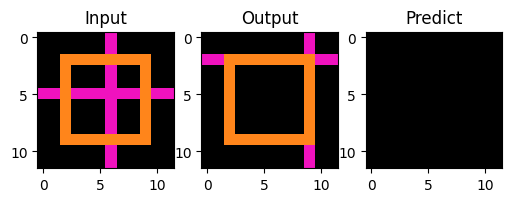

368it [00:36, 16.66it/s]

Accuracy:  0.06944444444444445


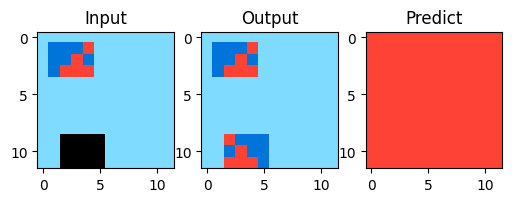

Accuracy:  0.5555555555555556


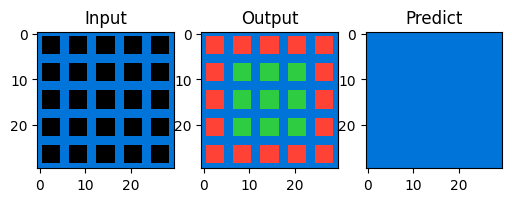

370it [00:36, 12.78it/s]

Accuracy:  0.0


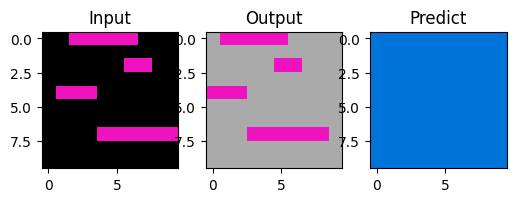

Accuracy:  0.5457063711911357


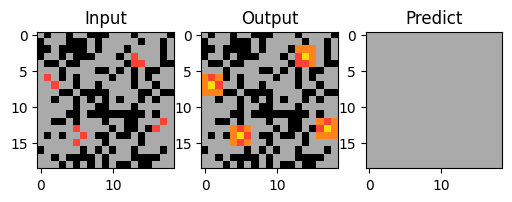

372it [00:36, 10.89it/s]

Accuracy:  0.7795857988165681


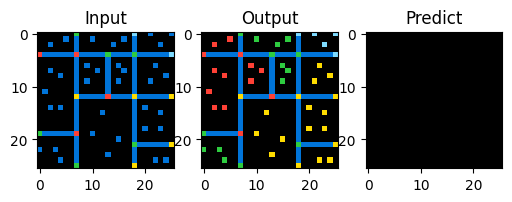

374it [00:36, 11.90it/s]

Accuracy:  0.683076923076923


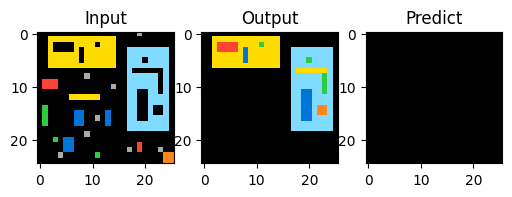

Accuracy:  0.8224852071005917


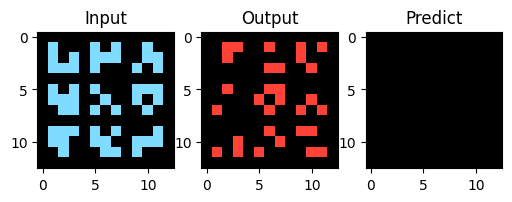

376it [00:37, 10.30it/s]

Accuracy:  0.6730769230769231


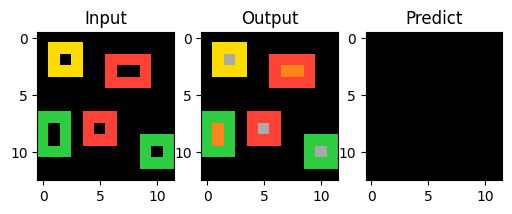

378it [00:37,  9.95it/s]

Accuracy:  0.29


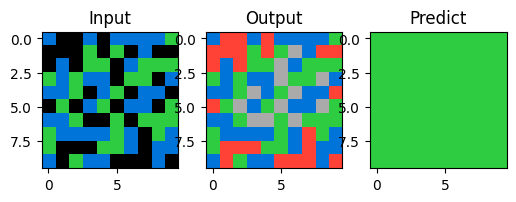

380it [00:37, 11.30it/s]

Accuracy:  0.6975425330812854


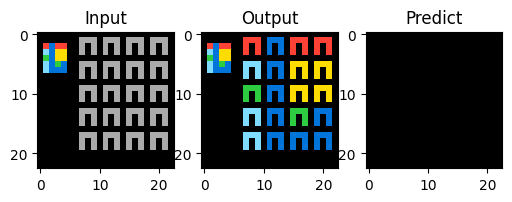

382it [00:37, 12.64it/s]

Accuracy:  0.4033333333333333


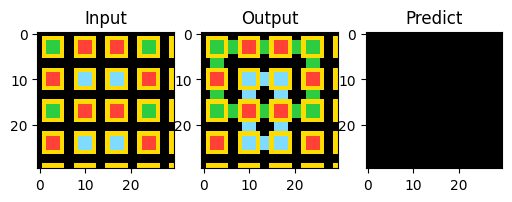

384it [00:37, 13.06it/s]

Accuracy:  0.5


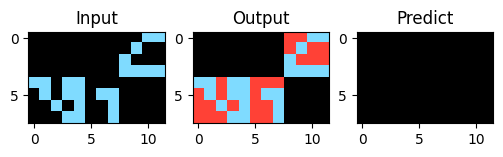

Accuracy:  0.6888888888888889


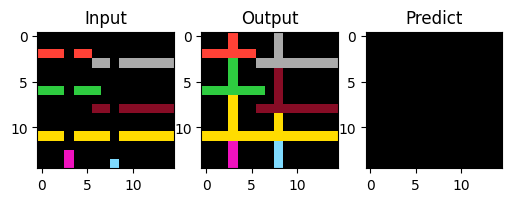

386it [00:37, 11.23it/s]

Accuracy:  0.75


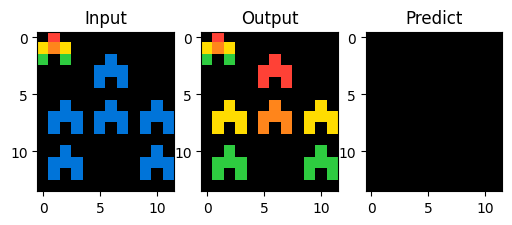

388it [00:38, 12.03it/s]

Accuracy:  0.90625


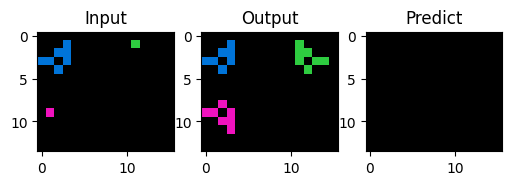

390it [00:38, 13.12it/s]

Accuracy:  0.4305555555555556


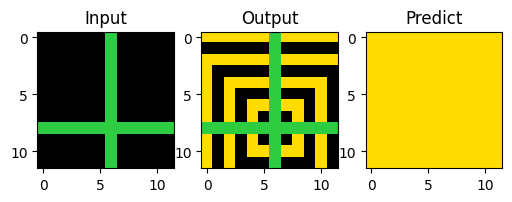

Accuracy:  0.7555555555555555


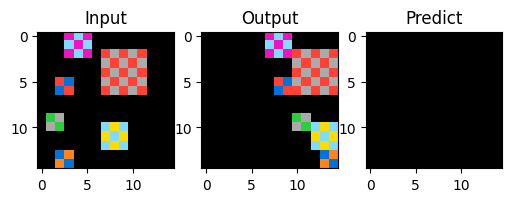

392it [00:38, 10.80it/s]

Accuracy:  0.92


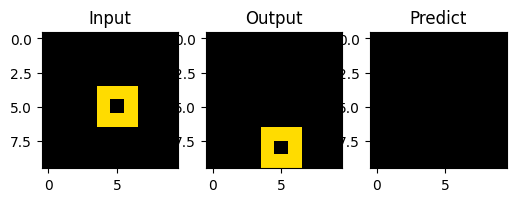

Accuracy:  0.92


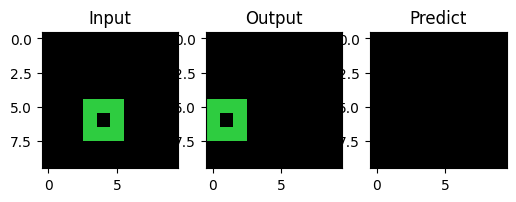

395it [00:38, 10.98it/s]

Accuracy:  0.8131868131868132


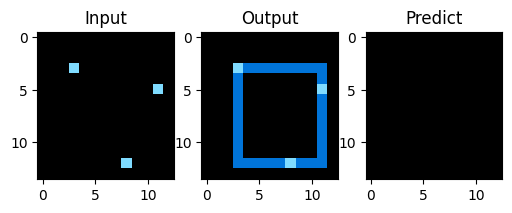

400it [00:38, 10.28it/s]


In [14]:
global model_failure
global model_success
global total_accuracy
global accuracy100
global accuracy95
global accuracy90
global accuracy80a
global accuracy80b

total_accuracy = 0
model_failure = 0
model_success = 0
accuracy100 = 0
accuracy95 = 0
accuracy90 = 0
accuracy80a = 0
accuracy80b = 0

for task, prediction, solved in tqdm(zip(eval_tasks.values(), train_predictions1, train_solved1)):
    # if solved:
    for i in range(len(task['test'])):
        # We have considered a task oly if the dimensions of output and prediction are same
        if (len(prediction[i]) == len(task['test'][i]['output'])) and (len(prediction[i][0]) == len(task['test'][i]['output'][0])):
            acc = get_accuracy(np.array(task['test'][i]['output']), np.array(prediction[i]))
            print("Accuracy: ", acc)
            if (acc == 1.0):
                accuracy100 += 1
            elif (acc >= 0.95):
                accuracy95 += 1
            elif (acc >= 0.9):
                accuracy90 += 1
            elif (acc >= 0.8):
                accuracy80a += 1
            else:
                accuracy80b += 1
            
            total_accuracy += acc
            plot_sample(task['test'][i], prediction[i])
            model_success += 1
        else:
            model_failure += 1

In [15]:
print("Total Accuracy: ", total_accuracy / model_success)
print("Accuracy 100: ", accuracy100)
print("Accuracy 95 - 100: ", accuracy95)
print("Accuracy 90 - 95: ", accuracy90)
print("Accuracy 80 - 90: ", accuracy80a)
print("Accuracy < 80: ", accuracy80b)
print("Model runs successfully for ", model_success, "tasks")
print("Model fails for ", model_failure, "tasks")

Total Accuracy:  0.6091580406788928
Accuracy 100:  0
Accuracy 95 - 100:  3
Accuracy 90 - 95:  14
Accuracy 80 - 90:  46
Accuracy < 80:  214
Model runs successfully for  277 tasks
Model fails for  142 tasks
